# DivPs analysis Formenti Demaria Blosum 45 distance metric 50000 random samples


TCRDivER analysis of the Murine dataset with Blosum45 distance used as TCR distance metric. 

**Instructions** 

Set path to working directory which should contain: 

* divP_tsv directory: containting all the diversities calculated at varying $q$ and $\lambda$s the TCRDivER algorithm outputs
* filtered directory: containing all the filetered TCR repertoires the TCRDivER algorithm outputs


In [75]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [76]:
def plt_divP(divP_df, sample_name, time, treatment, patient, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    plt.figure(figsize=(6,8))
    sns.color_palette("colorblind")
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(patient, fontsize = 20)
    if not os.path.isdir(wdir_path+"divPs/"):
        os.makedirs(wdir_path+"divPs/", exist_ok=False)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [77]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [78]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [79]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [80]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [81]:
# Set path to working directory:
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/2018_Formenti_Demaria_Lung_50000/"



Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

In [83]:
#read in filtered filenames and count unique CDR3s
filtered_fpath = wdir_path + "filtered/"
files = [f for f in listdir(filtered_fpath) if isfile(join(filtered_fpath, f))]
files = [f for f in listdir(filtered_fpath) if f.endswith(".tsv")]
unique_CDR3s_dict = defaultdict()
for file in files: 
    num_lines = sum(1 for line in open(filtered_fpath+file))
    unique_CDR3s_dict["_".join(file.split("_")[:-1])]=num_lines

print(files)


# Read in metadata: 
mddf_list = list()

for k,v in unique_CDR3s_dict.items():
    mddf_list.append([k] + k.split("_") + [v])
    

mddf = pd.DataFrame(mddf_list, columns = ["sample_name", "patient", "RECIST", "sample_type", "timepoint", "unique_CDR3s"])
mddf

['Pt43_PD_PBMC_Day22_filtered.tsv', 'Pt22_SD_PBMC_Day22_filtered.tsv', 'Pt43_PD_PBMC_Day0_filtered.tsv', 'Pt5_SD_PBMC_Day0_filtered.tsv', 'Pt1_PR_PBMC_Day0_filtered.tsv', 'Pt36_PD_PBMC_Day22_filtered.tsv', 'Pt36_PD_PBMC_Day0_filtered.tsv', 'Pt44_PR_PBMC_Day22_filtered.tsv', 'Pt27_PD_PBMC_Day22_filtered.tsv', 'Pt37_PR_PBMC_Day0_filtered.tsv', 'Pt10_PD_PBMC_Day0_filtered.tsv', 'Pt32_SD_PBMC_Day22_filtered.tsv', 'Pt37_PR_PBMC_Day22_filtered.tsv', 'Pt23_PR_PBMC_Day0_filtered.tsv', 'Pt4_CR_PBMC_Day0_filtered.tsv', 'Pt32_SD_PBMC_Day0_filtered.tsv', 'Pt40_PD_PBMC_Day0_filtered.tsv', 'Pt38_PD_PBMC_Day22_filtered.tsv', 'Pt17_PR_PBMC_Day0_filtered.tsv', 'Pt1_PR_PBMC_Day22_filtered.tsv', 'Pt10_PD_PBMC_Day22_filtered.tsv', 'Pt16_PD_PBMC_Day0_filtered.tsv', 'Pt3_CR_PBMC_Day0_filtered.tsv', 'Pt38_PD_PBMC_Day0_filtered.tsv', 'Pt30_SD_PBMC_Day22_filtered.tsv', 'Pt9_SD_PBMC_Day0_filtered.tsv', 'Pt40_PD_PBMC_Day22_filtered.tsv', 'Pt23_PR_PBMC_Day22_filtered.tsv', 'Pt4_CR_PBMC_Day22_filtered.tsv', 'Pt28_

sample_name patient RECIST sample_type timepoint  unique_CDR3s
0   Pt43_PD_PBMC_Day22    Pt43     PD        PBMC     Day22         32983
1   Pt22_SD_PBMC_Day22    Pt22     SD        PBMC     Day22         30146
2    Pt43_PD_PBMC_Day0    Pt43     PD        PBMC      Day0         32998
3     Pt5_SD_PBMC_Day0     Pt5     SD        PBMC      Day0         36074
4     Pt1_PR_PBMC_Day0     Pt1     PR        PBMC      Day0         33446
5   Pt36_PD_PBMC_Day22    Pt36     PD        PBMC     Day22         22467
6    Pt36_PD_PBMC_Day0    Pt36     PD        PBMC      Day0         21211
7   Pt44_PR_PBMC_Day22    Pt44     PR        PBMC     Day22         28538
8   Pt27_PD_PBMC_Day22    Pt27     PD        PBMC     Day22         17699
9    Pt37_PR_PBMC_Day0    Pt37     PR        PBMC      Day0         33824
10   Pt10_PD_PBMC_Day0    Pt10     PD        PBMC      Day0         39555
11  Pt32_SD_PBMC_Day22    Pt32     SD        PBMC     Day22         19849
12  Pt37_PR_PBMC_Day22    Pt37     PR        PBMC     Day22         35062
13   Pt23_PR_PBMC_Day0    Pt23     PR        PBMC      Day0         16753
14    Pt4_CR_PBMC_Day0     Pt4     CR        PBMC      Day0         27209
15   Pt32_SD_PBMC_Day0    Pt32     SD        PBMC      Day0         18287
16   Pt40_PD_PBMC_Day0    Pt40     PD        PBMC      Day0         20905
17  Pt38_PD_PBMC_Day22    Pt38     PD        PBMC     Day22         20022
18   Pt17_PR_PBMC_Day0    Pt17     PR        PBMC      Day0         37698
19   Pt1_PR_PBMC_Day22     Pt1     PR        PBMC     Day22         33568
20  Pt10_PD_PBMC_Day22    Pt10     PD        PBMC     Day22         39417
21   Pt16_PD_PBMC_Day0    Pt16     PD        PBMC      Day0         36110
22    Pt3_CR_PBMC_Day0     Pt3     CR        PBMC      Day0         29075
23   Pt38_PD_PBMC_Day0    Pt38     PD        PBMC      Day0         18942
24  Pt30_SD_PBMC_Day22    Pt30     SD        PBMC     Day22         20291
25    Pt9_SD_PBMC_Day0     Pt9     SD        PBMC      Day0         21371
26  Pt40_PD_PBMC_Day22    Pt40     PD        PBMC     Day22         26737
27  Pt23_PR_PBMC_Day22    Pt23     PR        PBMC     Day22         17549
28   Pt4_CR_PBMC_Day22     Pt4     CR        PBMC     Day22         29732
29  Pt28_PD_PBMC_Day22    Pt28     PD        PBMC     Day22         36018
30   Pt28_PD_PBMC_Day0    Pt28     PD        PBMC      Day0         38151
31   Pt9_SD_PBMC_Day22     Pt9     SD        PBMC     Day22         20669
32   Pt5_SD_PBMC_Day22     Pt5     SD        PBMC     Day22         36579
33   Pt30_SD_PBMC_Day0    Pt30     SD        PBMC      Day0         17423
34  Pt17_PR_PBMC_Day22    Pt17     PR        PBMC     Day22         32628
35   Pt44_PR_PBMC_Day0    Pt44     PR        PBMC      Day0         29786
36   Pt22_SD_PBMC_Day0    Pt22     SD        PBMC      Day0         26421
37  Pt16_PD_PBMC_Day22    Pt16     PD        PBMC     Day22         35294
38   Pt3_CR_PBMC_Day22     Pt3     CR        PBMC     Day22         27116
39   Pt27_PD_PBMC_Day0    Pt27     PD        PBMC      Day0         25848

## Plot Diversity Profiles for individual samples 

In [84]:
# load filenames: 
divP_fpath = wdir_path + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['Pt10_PD_PBMC_Day0_divP',
 'Pt10_PD_PBMC_Day22_divP',
 'Pt16_PD_PBMC_Day0_divP',
 'Pt16_PD_PBMC_Day22_divP',
 'Pt17_PR_PBMC_Day0_divP',
 'Pt17_PR_PBMC_Day22_divP',
 'Pt1_PR_PBMC_Day0_divP',
 'Pt1_PR_PBMC_Day22_divP',
 'Pt22_SD_PBMC_Day0_divP',
 'Pt22_SD_PBMC_Day22_divP',
 'Pt23_PR_PBMC_Day0_divP',
 'Pt23_PR_PBMC_Day22_divP',
 'Pt27_PD_PBMC_Day0_divP',
 'Pt27_PD_PBMC_Day22_divP',
 'Pt28_PD_PBMC_Day0_divP',
 'Pt28_PD_PBMC_Day22_divP',
 'Pt30_SD_PBMC_Day0_divP',
 'Pt30_SD_PBMC_Day22_divP',
 'Pt32_SD_PBMC_Day0_divP',
 'Pt32_SD_PBMC_Day22_divP',
 'Pt36_PD_PBMC_Day0_divP',
 'Pt36_PD_PBMC_Day22_divP',
 'Pt37_PR_PBMC_Day0_divP',
 'Pt37_PR_PBMC_Day22_divP',
 'Pt38_PD_PBMC_Day0_divP',
 'Pt38_PD_PBMC_Day22_divP',
 'Pt3_CR_PBMC_Day0_divP',
 'Pt3_CR_PBMC_Day22_divP',
 'Pt40_PD_PBMC_Day0_divP',
 'Pt40_PD_PBMC_Day22_divP',
 'Pt43_PD_PBMC_Day0_divP',
 'Pt43_PD_PBMC_Day22_divP',
 'Pt44_PR_PBMC_Day0_divP',
 'Pt44_PR_PBMC_Day22_divP',
 'Pt4_CR_PBMC_Day0_divP',
 'Pt4_CR_PBMC_Day22_divP',
 'Pt5_SD_PBMC_Da

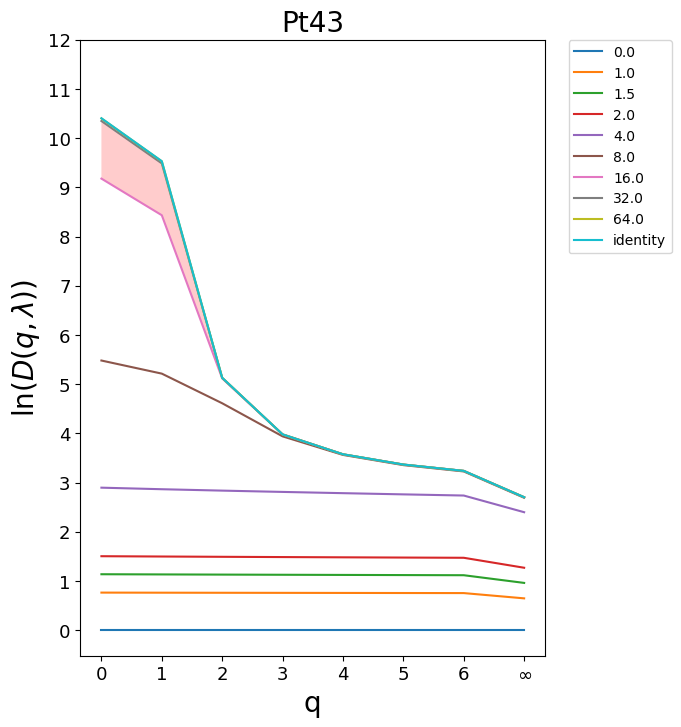

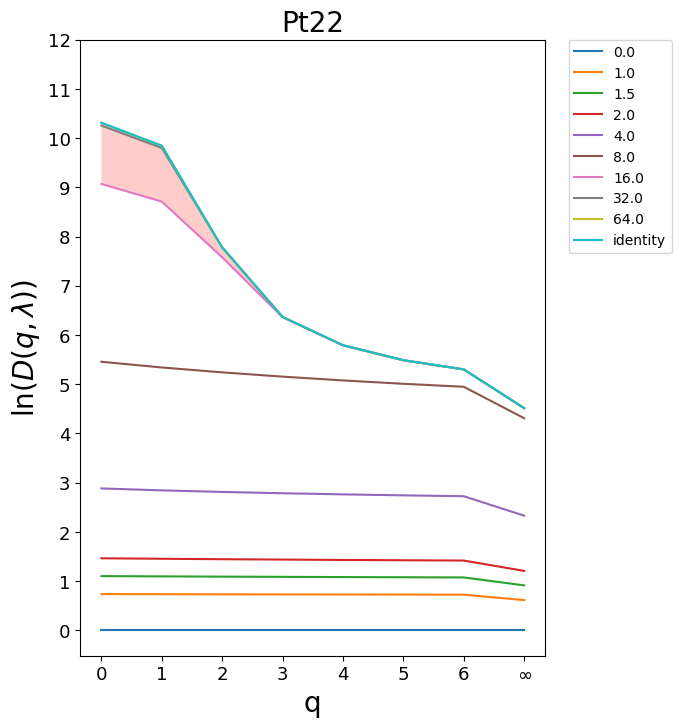

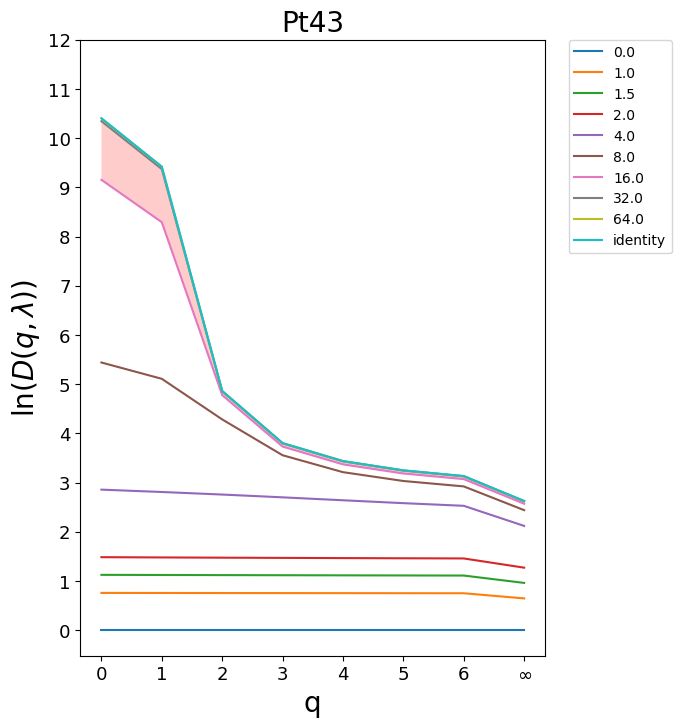

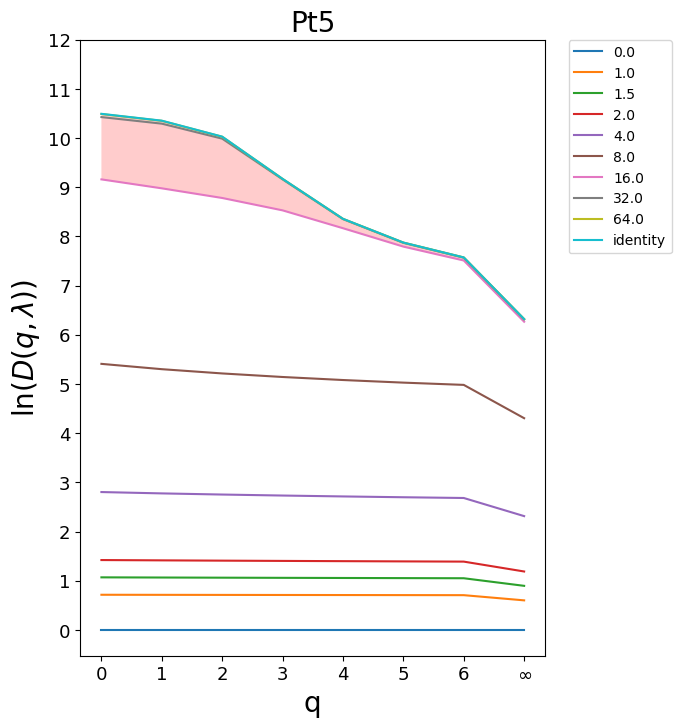

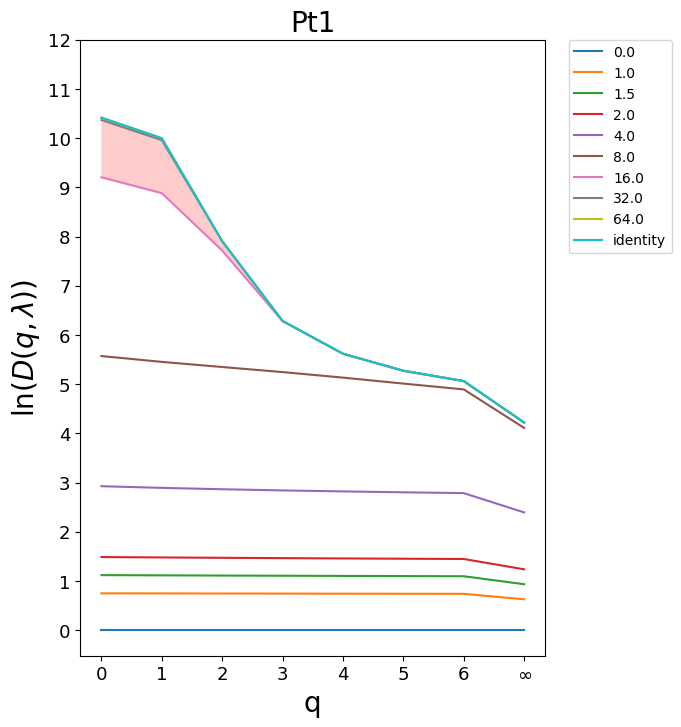

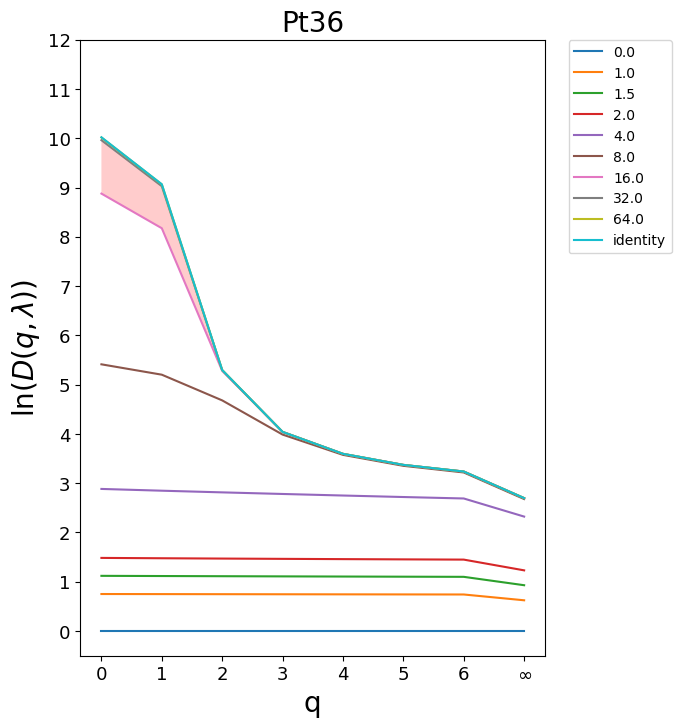

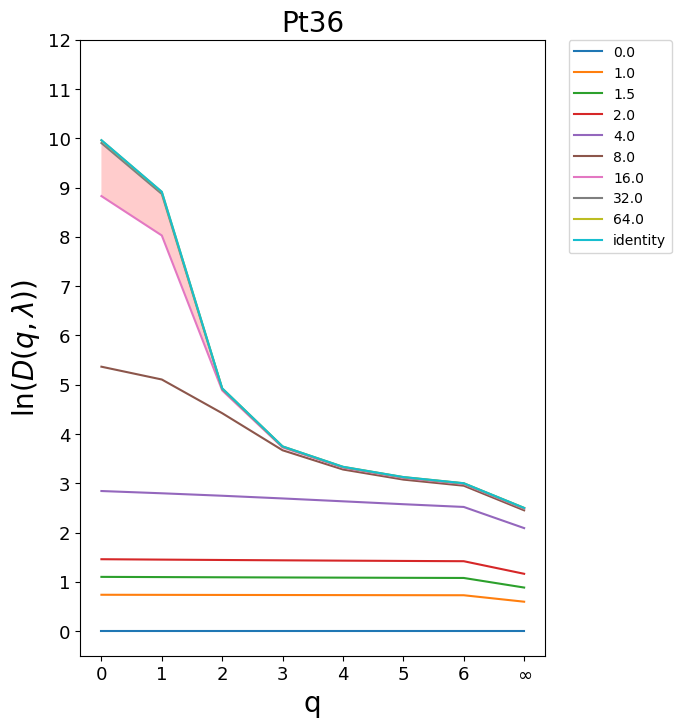

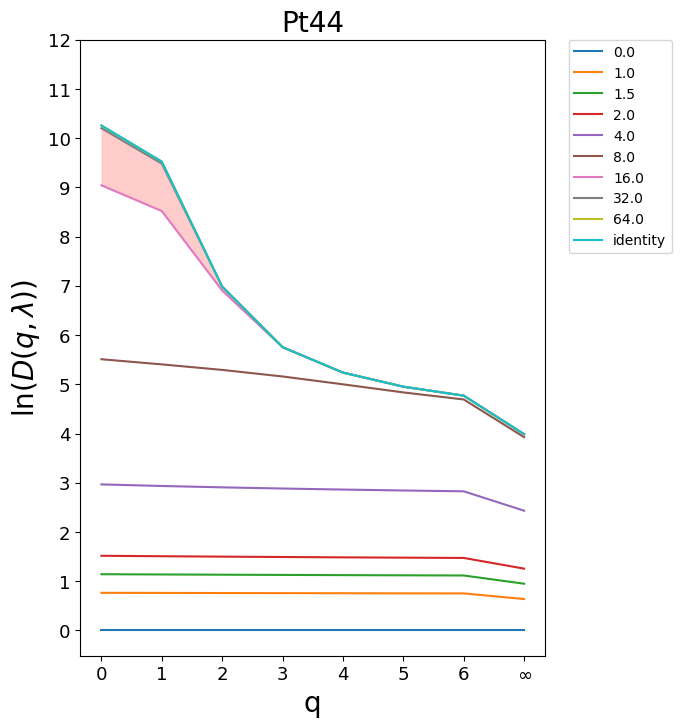

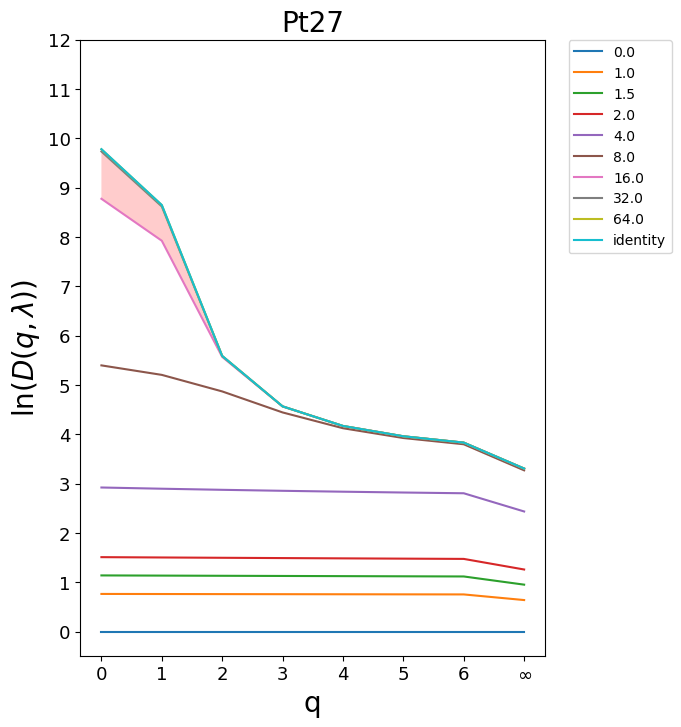

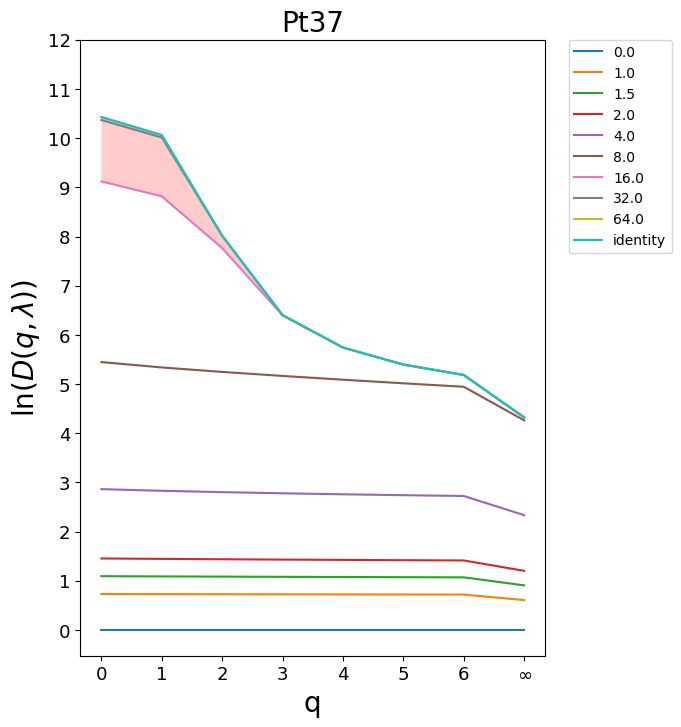

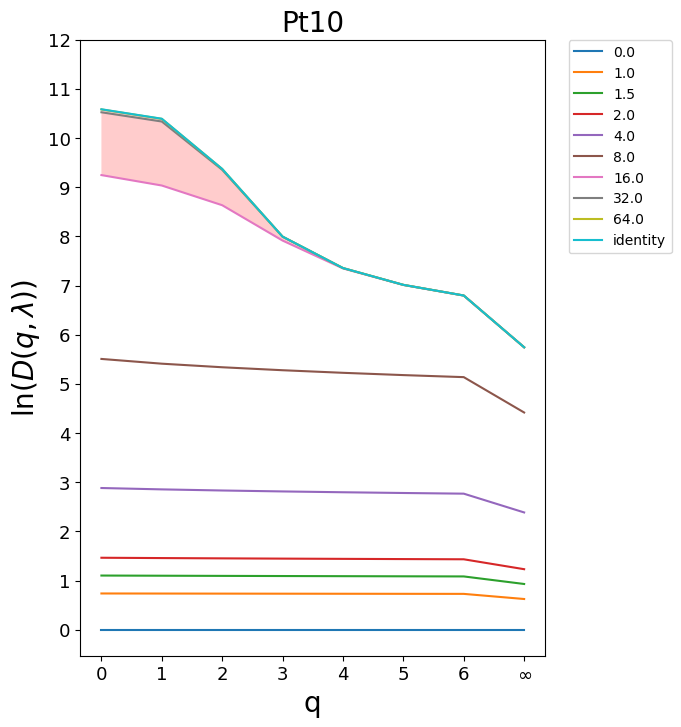

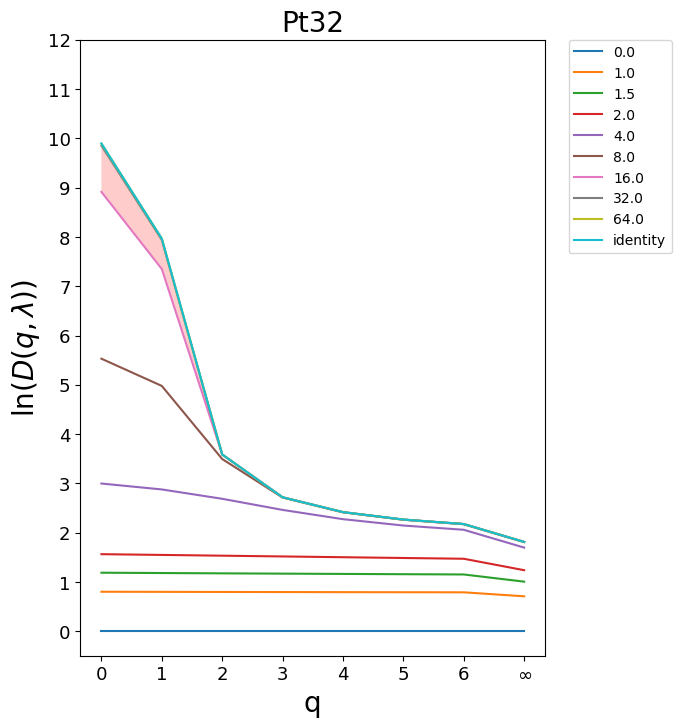

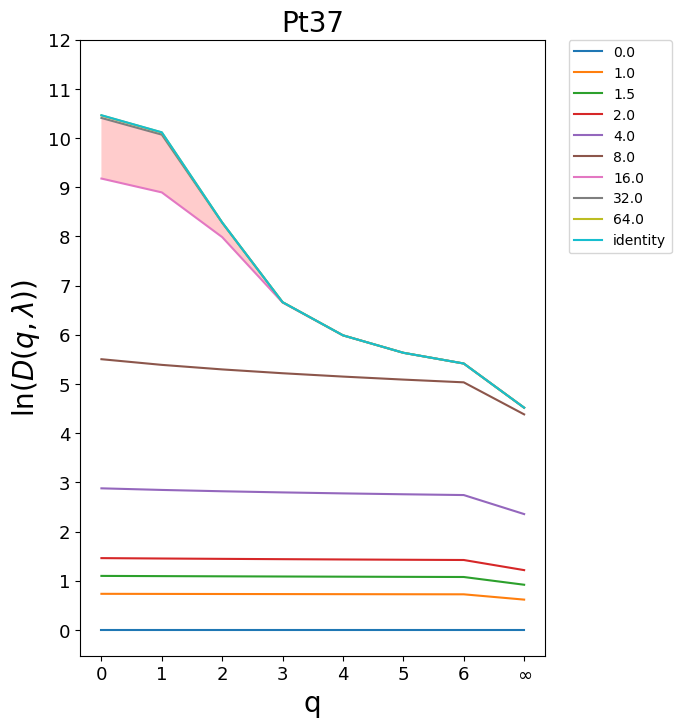

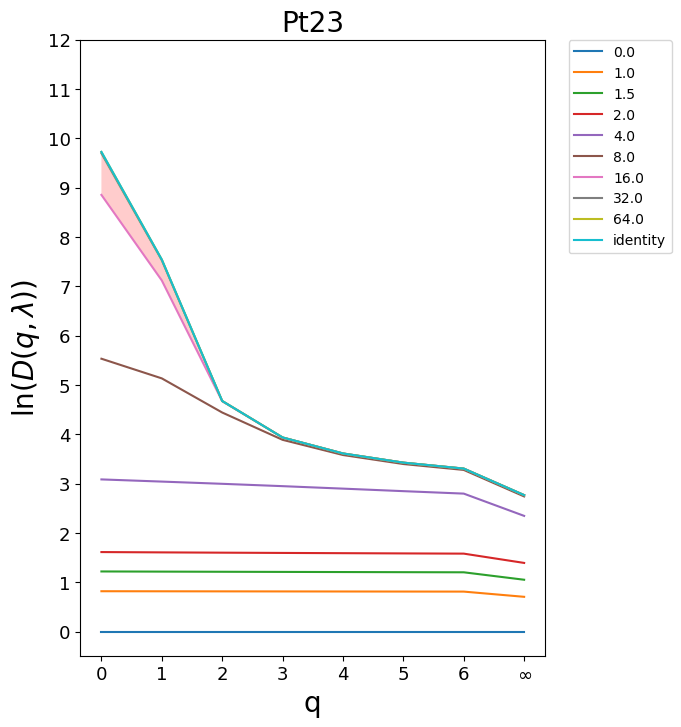

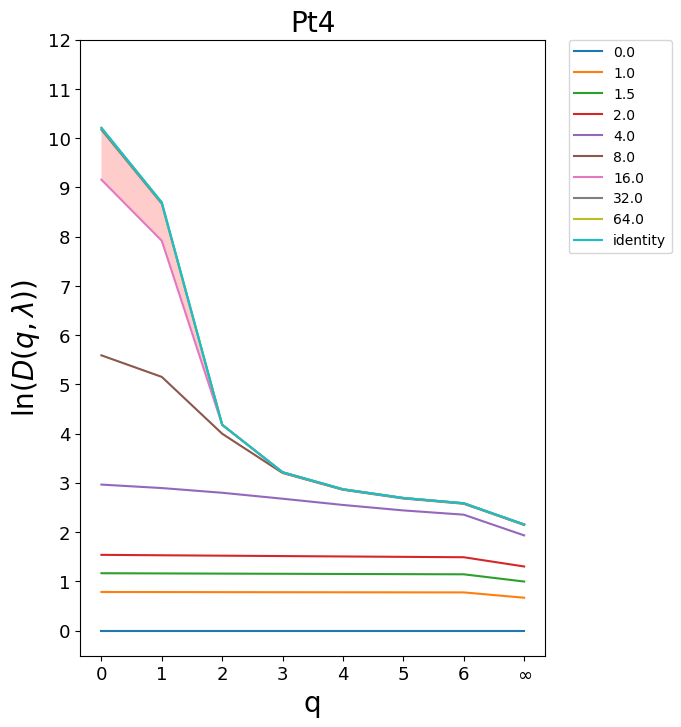

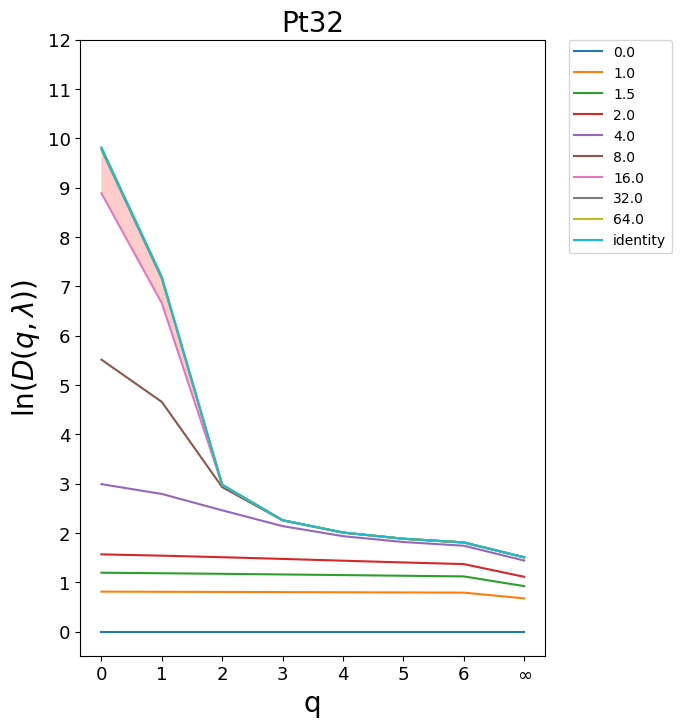

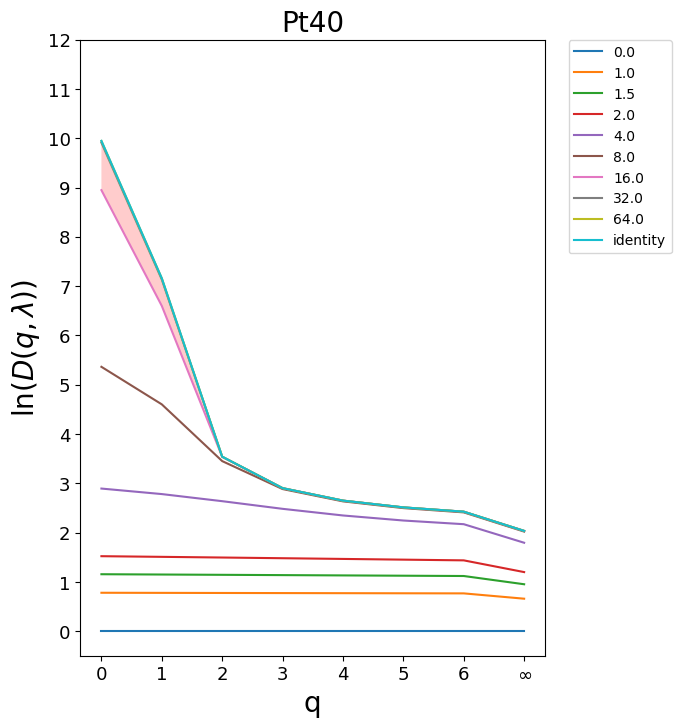

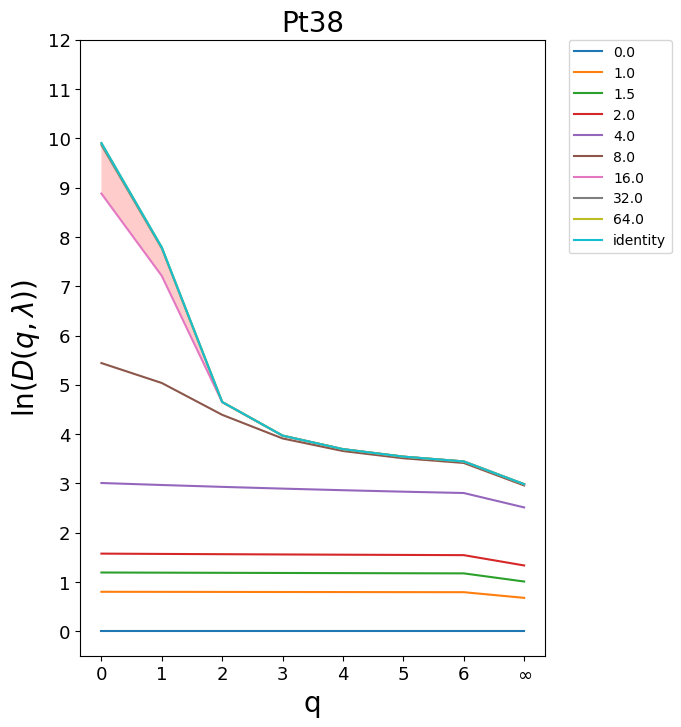

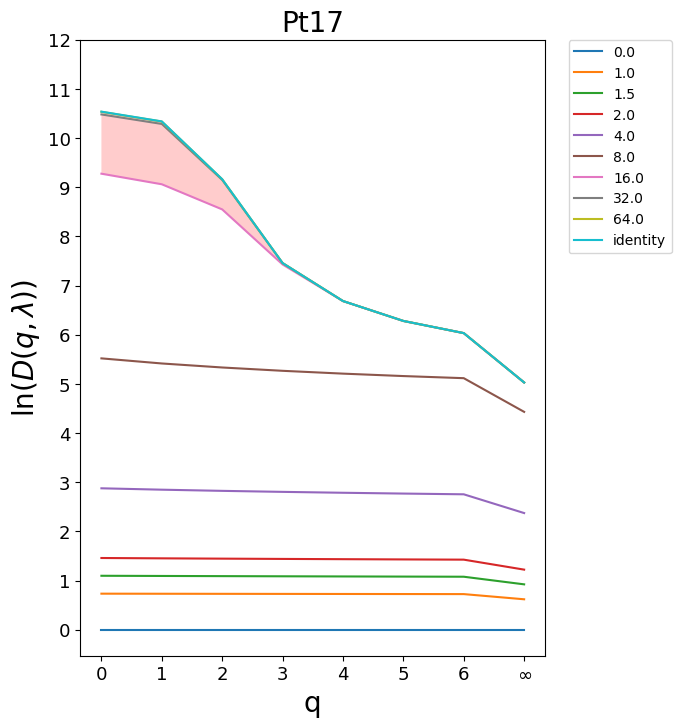

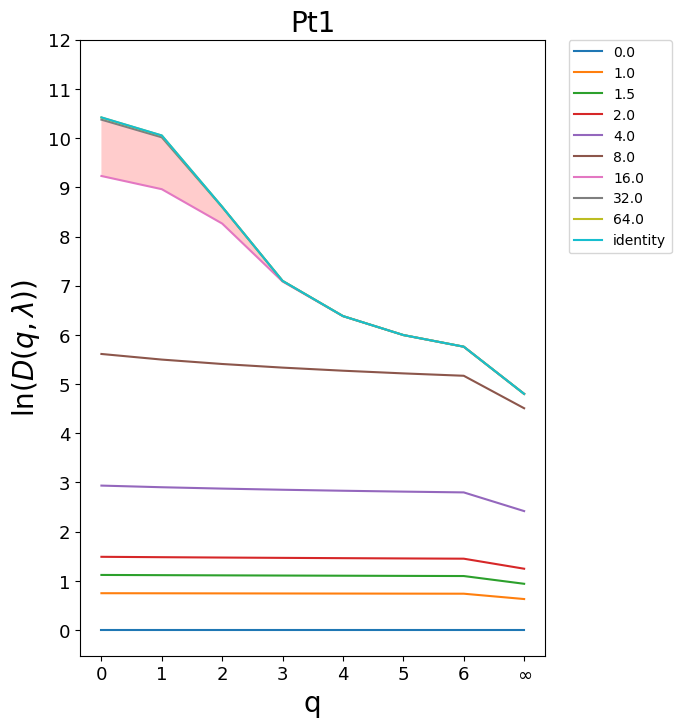

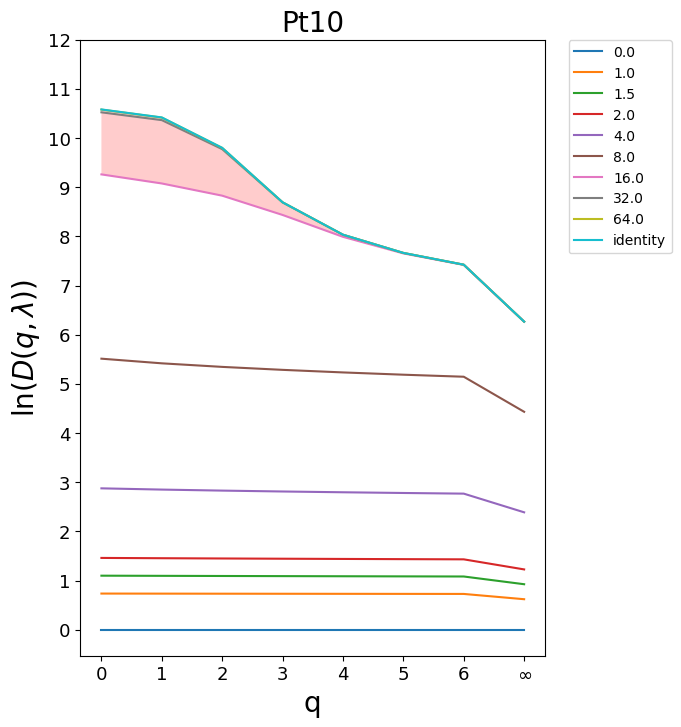

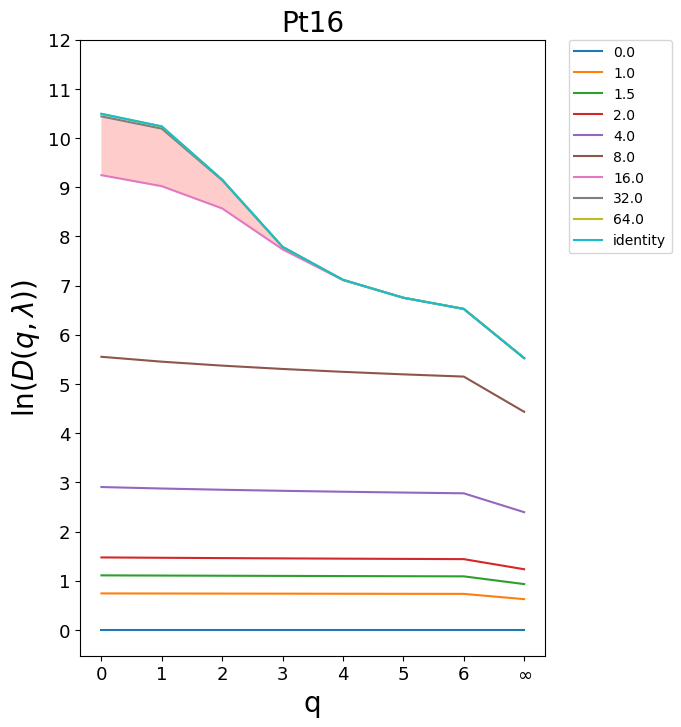

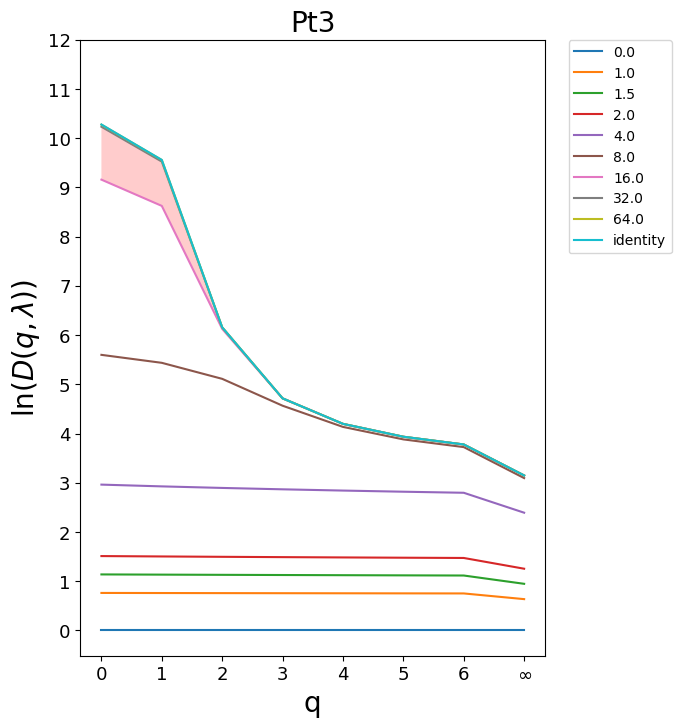

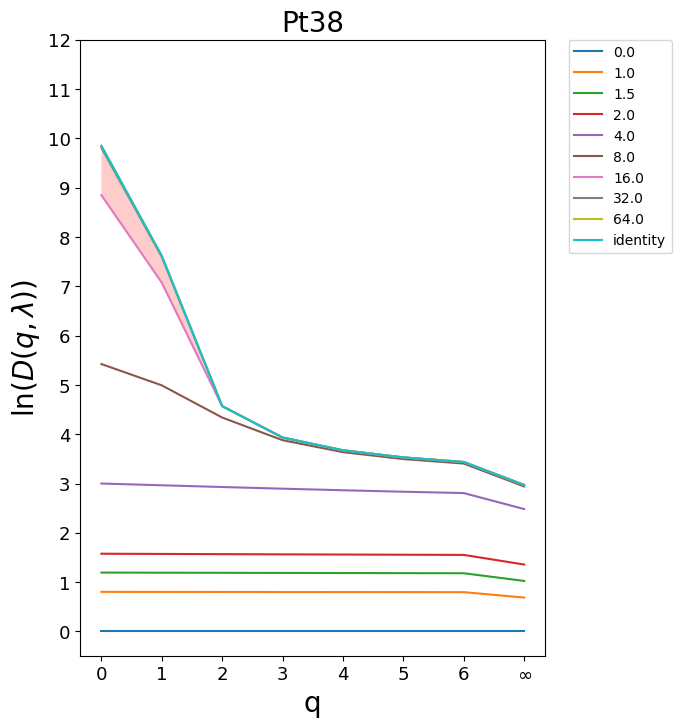

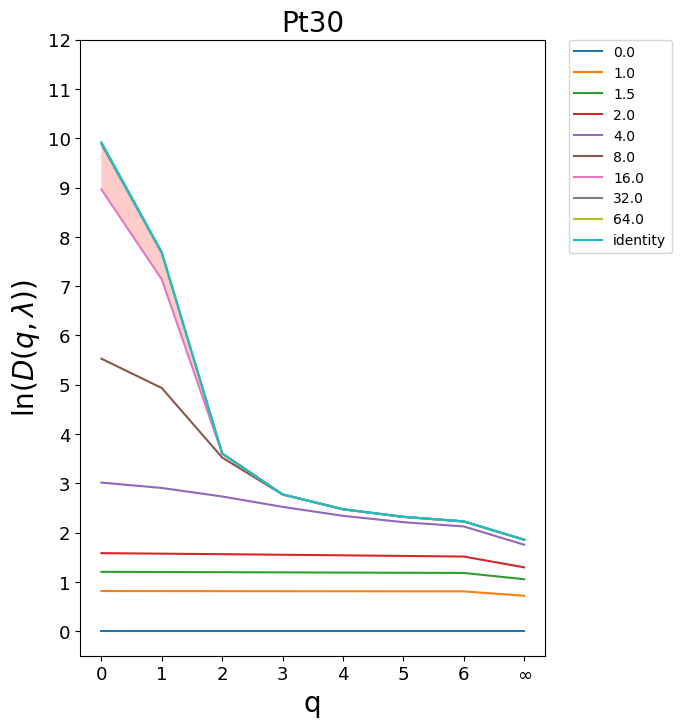

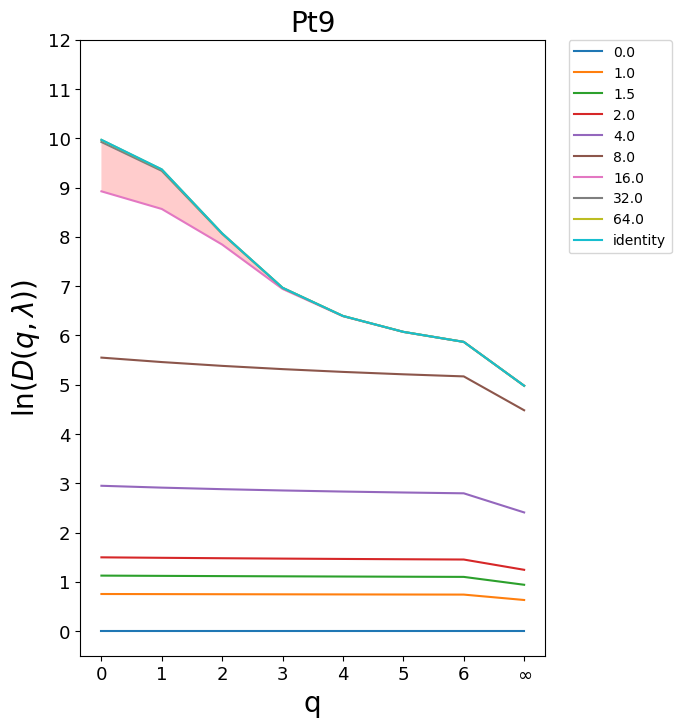

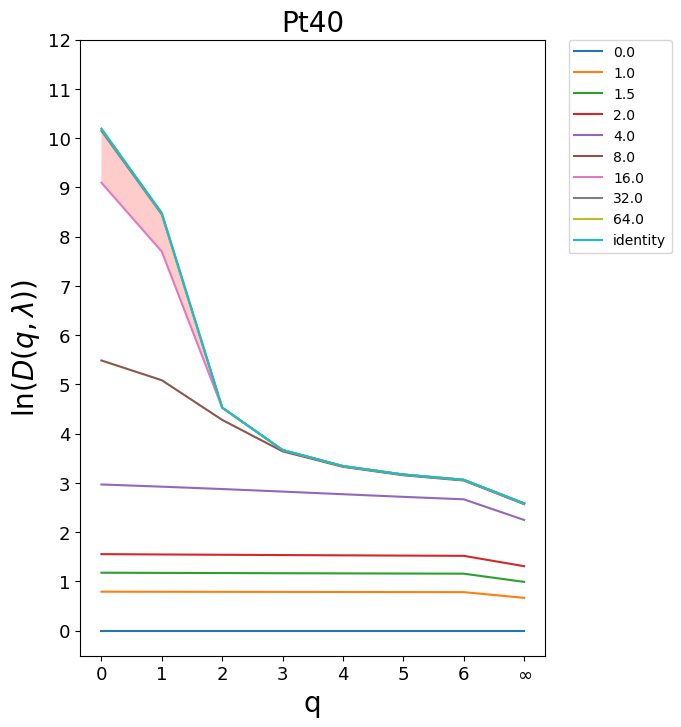

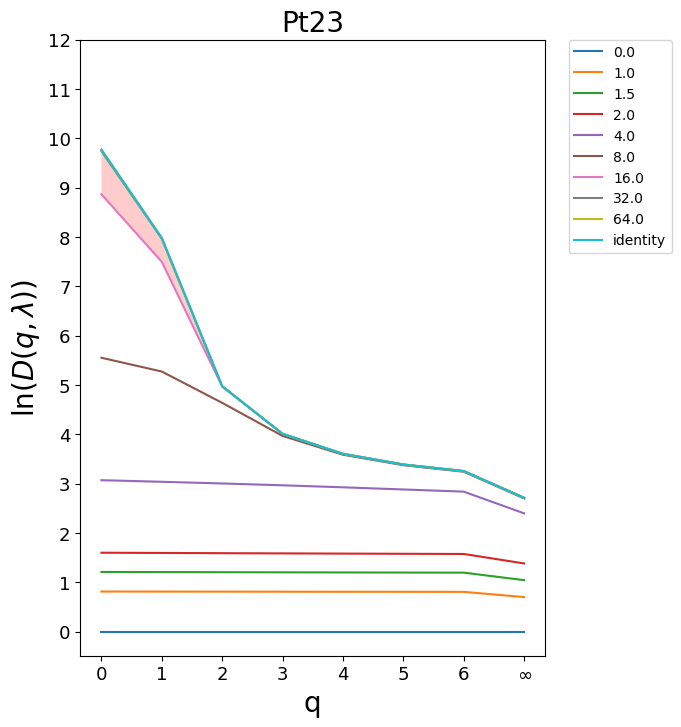

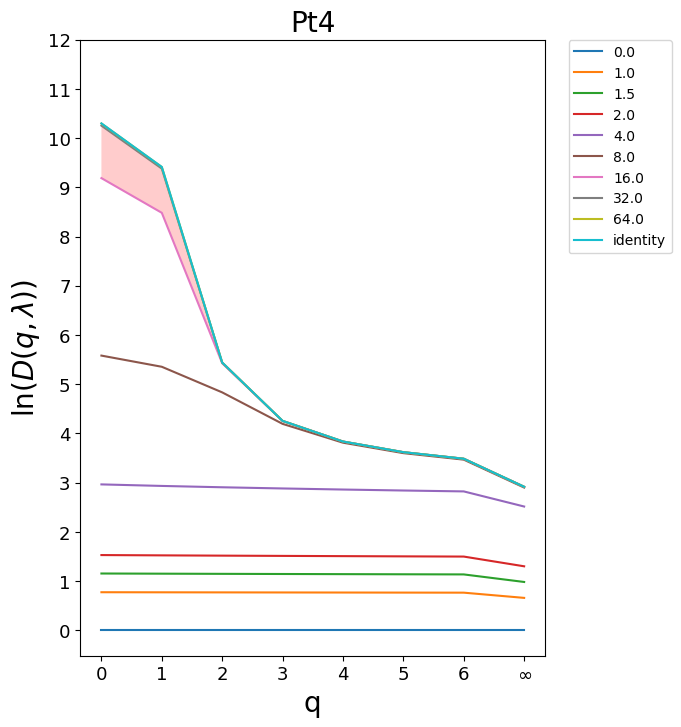

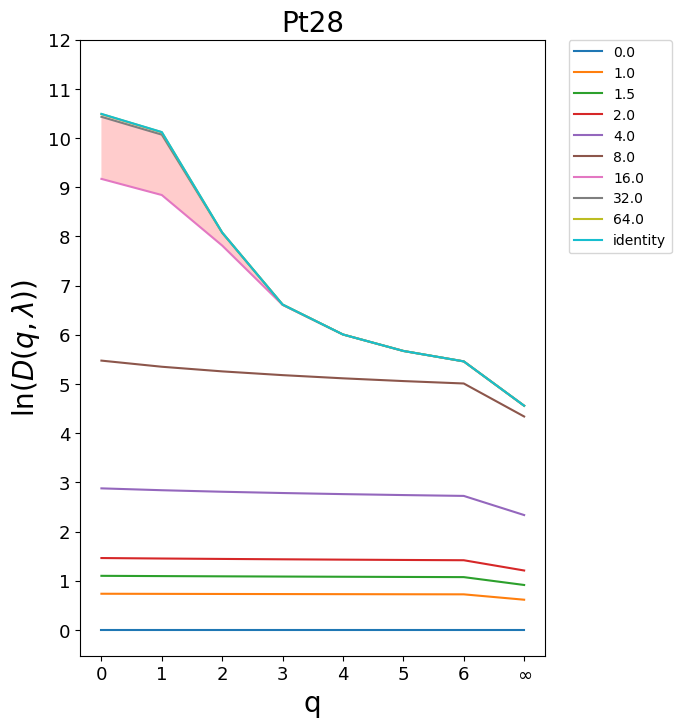

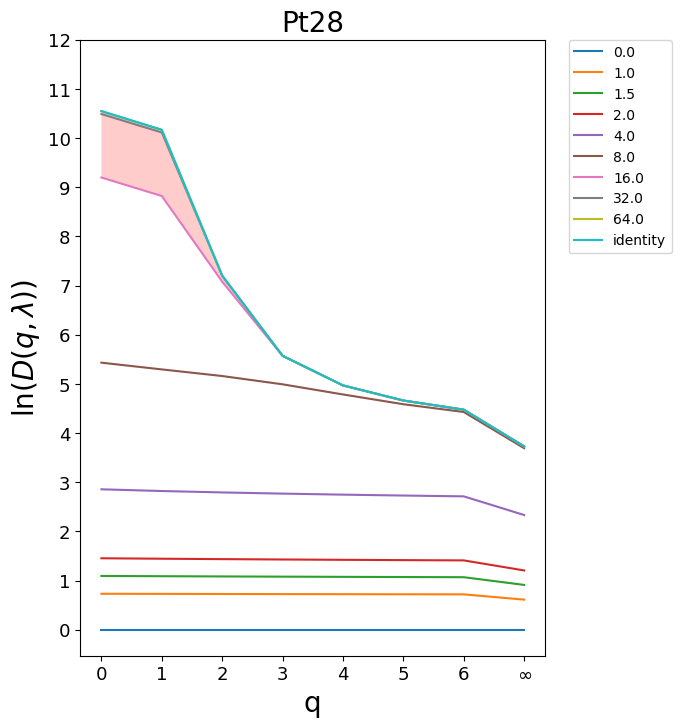

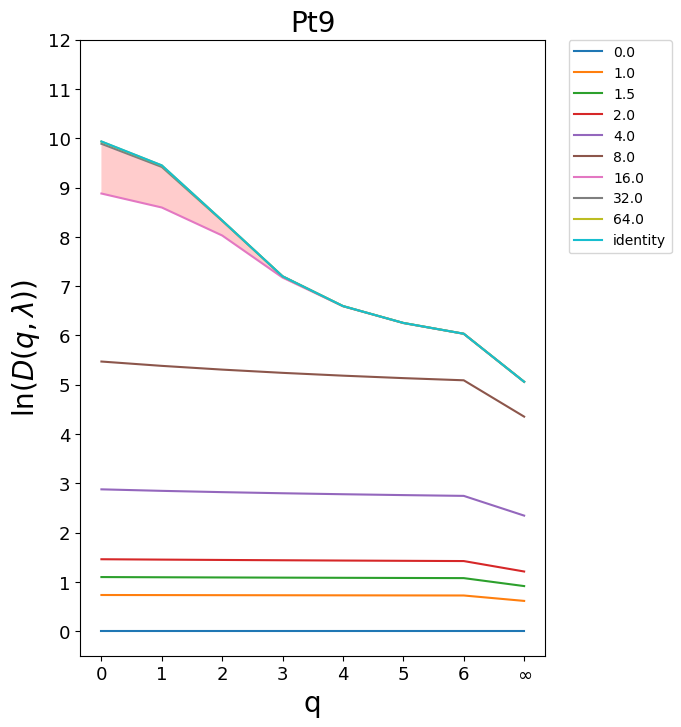

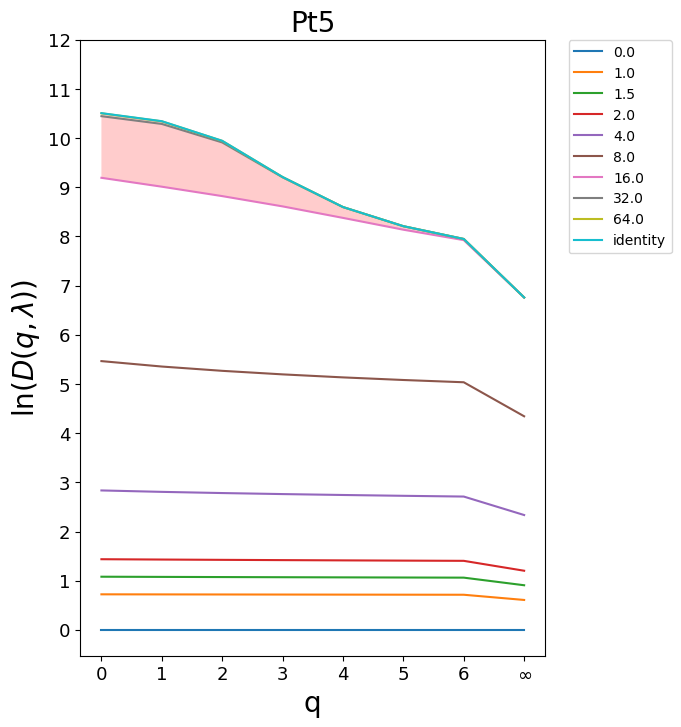

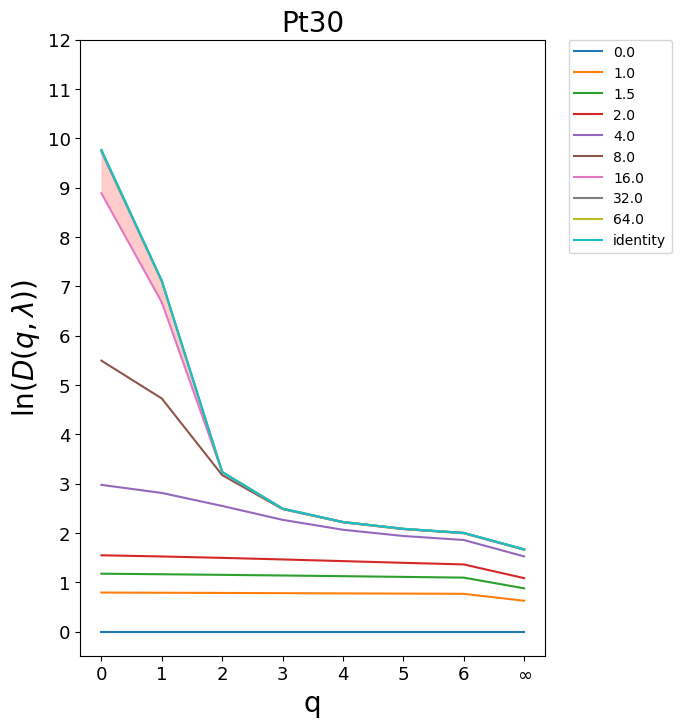

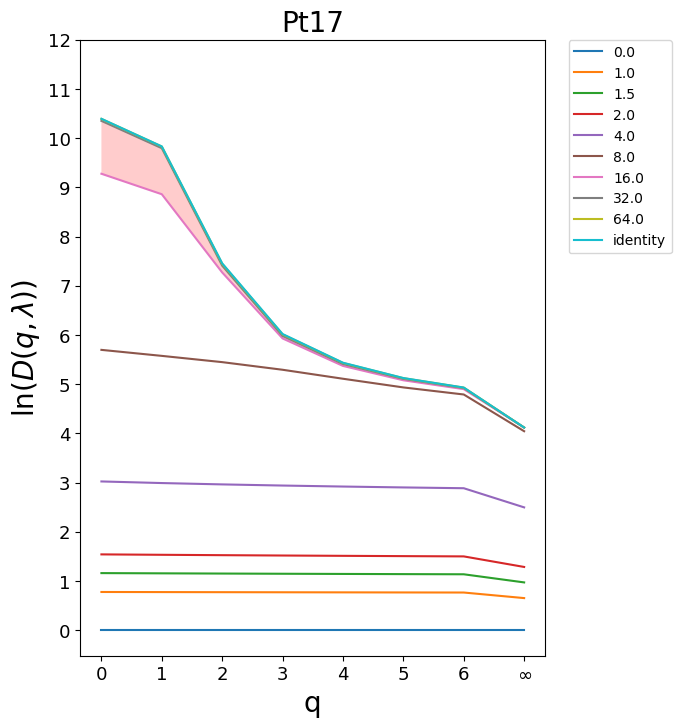

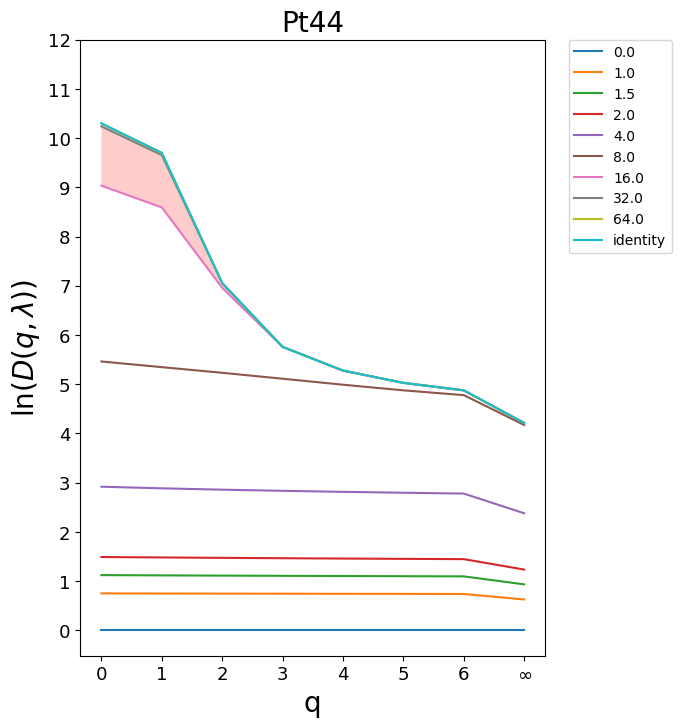

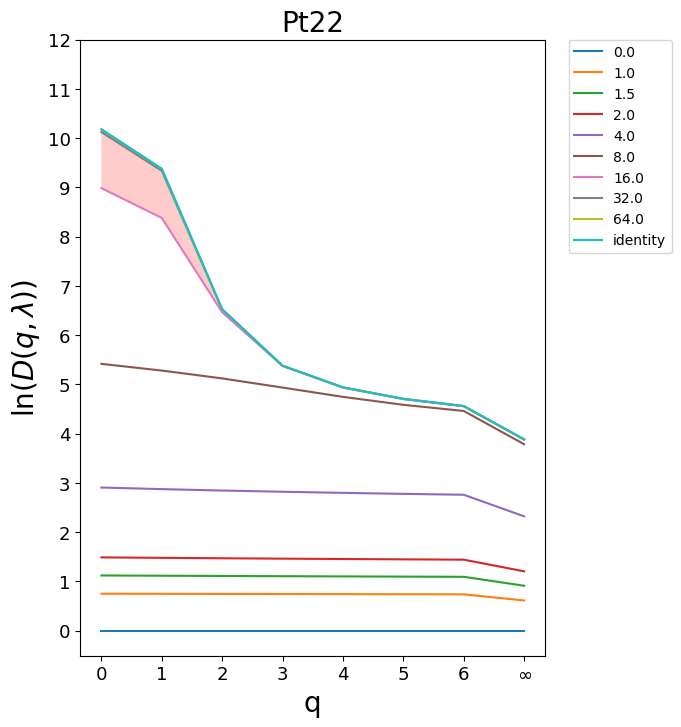

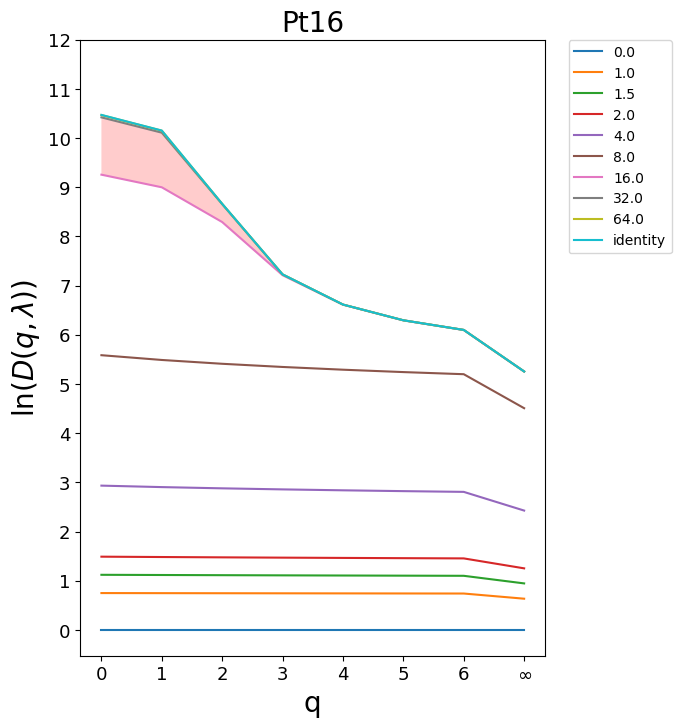

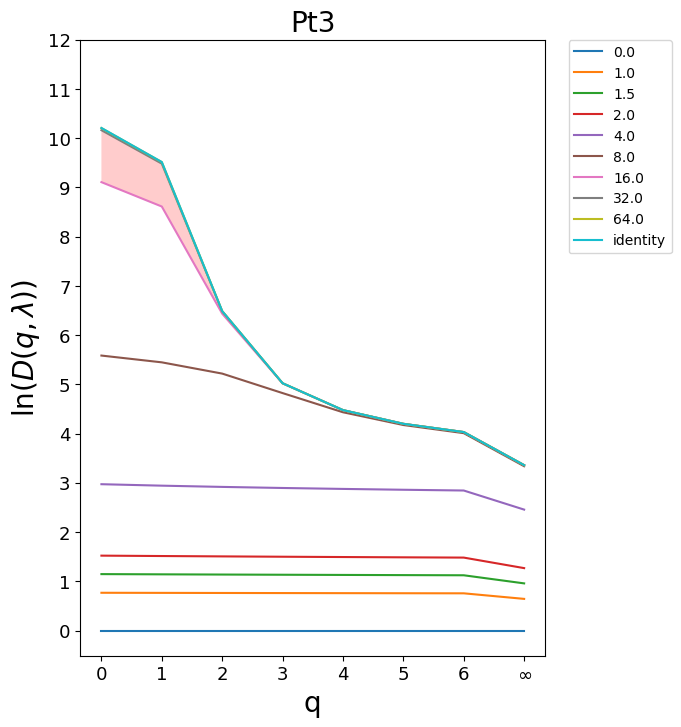

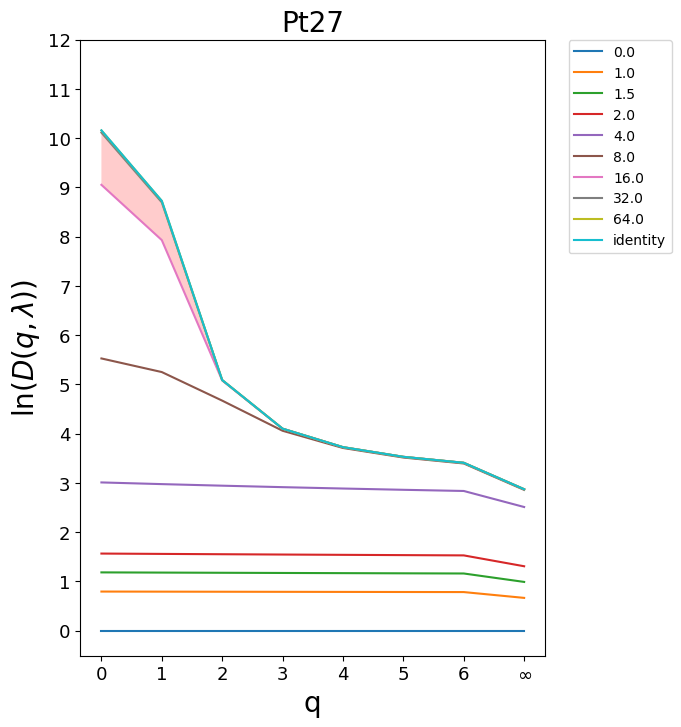

In [85]:
# define divP files 
divP_fpath = wdir_path + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
# iterate trough files 
for index,row in mddf.iterrows():
    # create pandas dataframes of divPs
    sample_name = row['sample_name']
    patient = row['patient']
    recist = row['RECIST']
    time = row['timepoint']
    divP_df = pd.read_csv(divP_fpath + row['sample_name'] + "_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    #calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, time, recist, patient, wdir_path)

divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df = pd.concat([divP1_all_df, mddf], axis = 1)

divP_features = pd.concat([divP_areas_df, divP_slopes_df,average_delta_lambda_df, mddf], axis=1)

In [86]:
divP_features = divP_features.rename(columns={"timepoint": "Timepoint", "RECIST": "RECIST criteria"})

In [87]:
divP_features["Timepoint"] = divP_features['Timepoint'].str.replace('Day', '')
divP_features["Timepoint"] = divP_features["Timepoint"].astype(str).astype(int)
divP_features = divP_features.sort_values('Timepoint')
divP_features = divP_features.reset_index(drop = True)
divP_features

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.003154            0.052764            1.358875   
1             0.002795            0.040914            1.049624   
2             0.003767            0.057244            1.527558   
3             0.004811            0.086275            2.484636   
4             0.004981            0.087676            2.146448   
5             0.005690            0.094025            2.554675   
6             0.004172            0.045051            1.064425   
7             0.006223            0.056192            1.000032   
8             0.002701            0.047180            1.309931   
9             0.005433            0.064419            1.585211   
10            0.001779            0.028917            0.879466   
11            0.001688            0.026617            0.864155   
12            0.005280            0.087440            2.160879   
13            0.004988            0.080530            1.842356   
14            0.012950            0.117370            1.579020   
15            0.004726            0.073446            1.672339   
16            0.003969            0.068071            1.922304   
17            0.008340            0.165351            4.292394   
18            0.005319            0.111252            2.129804   
19            0.005639            0.105352            2.857821   
20            0.007502            0.126206            4.027446   
21            0.031658            0.195414            1.948471   
22            0.005107            0.063750            1.723358   
23            0.005256            0.087447            2.215070   
24            0.004393            0.075845            2.152773   
25            0.003474            0.056711            1.502618   
26            0.002096            0.030749            0.948064   
27            0.004532            0.072749            1.724429   
28            0.002325            0.035830            1.028368   
29            0.006197            0.112708            3.291892   
30            0.003852            0.059167            1.507901   
31            0.002713            0.041293            1.097490   
32            0.004876            0.081102            2.171739   
33            0.003749            0.048608            1.110679   
34            0.004027            0.053487            1.248906   
35            0.004588            0.071628            1.698957   
36            0.004677            0.068403            1.480501   
37            0.005203            0.079115            1.978866   
38            0.003651            0.052283            1.336555   
39            0.003805            0.066967            2.044456   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0            6.302410          14.920070          24.401665   
1            5.241175          13.134423          22.329857   
2            7.852819          19.231063          28.749971   
3           18.868373          36.007252          45.522476   
4           10.377730          25.018785          34.297884   
5           17.263229          34.324567          43.765365   
6            5.008369          10.169219          16.980521   
7            4.740312           8.691892          13.719442   
8            6.086245          12.256709          19.947123   
9           13.402917          30.448930          40.029429   
10           4.618687           9.127832          14.880077   
11           4.885813          12.493838          21.678471   
12          12.523683          28.938955          38.270639   
13           9.801190          25.341119          34.816798   
14           6.872415          14.850248          23.365669   
15           8.787075          23.034025          32.422907   
16          11.538427          27.801274          37.335864   
17          26.162466          42.856371          52.058958   
18           8.364247          15.915500          24.235412   
19          20.562204          37.617

In [88]:
divP1_all_df = divP1_all_df.rename(columns={"timepoint": "Timepoint", "RECIST": "RECIST criteria"})
divP1_all_df["Timepoint"] = divP1_all_df['Timepoint'].str.replace('Day', '')
divP1_all_df["Timepoint"] = divP1_all_df["Timepoint"].astype(str).astype(int)
divP1_all_df = divP1_all_df.sort_values('Timepoint')
divP1_all_df = divP1_all_df.reset_index(drop = True)
divP1_all_df


L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.080324  0.080305  0.080286  0.080267  0.080248  0.080229  0.080211   
1    0.08131    0.0813  0.081289  0.081279  0.081268  0.081258  0.081247   
2   0.076677  0.076659  0.076641  0.076623  0.076606  0.076588   0.07657   
3   0.074625  0.074609  0.074593  0.074576   0.07456  0.074544  0.074528   
4   0.073666  0.073645  0.073623  0.073601   0.07358  0.073559  0.073538   
5   0.073927  0.073911  0.073896   0.07388  0.073864  0.073849  0.073833   
6   0.079482  0.079467  0.079452  0.079437  0.079421  0.079406  0.079391   
7   0.083516  0.083502  0.083489  0.083475  0.083462  0.083448  0.083435   
8   0.079534  0.079521  0.079508  0.079494  0.079481  0.079468  0.079455   
9   0.075801  0.075779  0.075757  0.075736  0.075714  0.075693  0.075672   
10  0.080873  0.080847  0.080821  0.080794  0.080768  0.080742  0.080715   
11  0.083094  0.083081  0.083068  0.083055  0.083042  0.083029  0.083017   
12  0.073693  0.073673  0.073653  0.073633  0.073614  0.073594  0.073575   
13  0.075603  0.075581  0.075559  0.075537  0.075516  0.075494  0.075473   
14  0.074545  0.074528  0.074511  0.074494  0.074477   0.07446  0.074443   
15  0.075521  0.075498  0.075475  0.075452  0.075429  0.075406  0.075384   
16   0.07517  0.075151  0.075133  0.075114  0.075096  0.075077  0.075059   
17  0.071877  0.071863  0.071849  0.071834   0.07182  0.071806  0.071792   
18  0.076792  0.076778  0.076765  0.076751  0.076737  0.076723   0.07671   
19  0.074148  0.074133  0.074119  0.074104  0.074089  0.074074   0.07406   
20  0.072712  0.072696  0.072681  0.072666  0.072651  0.072636  0.072621   
21  0.078068  0.078048  0.078029  0.078009  0.077989   0.07797   0.07795   
22  0.073914  0.073896  0.073879  0.073862  0.073844  0.073827   0.07381   
23  0.073976  0.073953  0.073931  0.073909  0.073888  0.073866  0.073844   
24  0.075472  0.075455  0.075439  0.075422  0.075406  0.075389  0.075373   
25  0.078242  0.078225  0.078209  0.078192  0.078176  0.078159  0.078143   
26  0.082234  0.082222   0.08221  0.082198  0.082186  0.082174  0.082162   
27  0.077082  0.077062  0.077043  0.077024  0.077005  0.076986  0.076967   
28  0.083537  0.083529  0.083521  0.083513  0.083505  0.083497  0.083489   
29  0.073975  0.073961  0.073948  0.073934  0.073921  0.073908  0.073895   
30  0.077335  0.077315  0.077295  0.077274  0.077254  0.077234  0.077214   
31   0.08115  0.081136  0.081122  0.081107  0.081093  0.081079  0.081065   
32  0.073942  0.073924  0.073906  0.073888   0.07387  0.073852  0.073835   
33  0.082048  0.082032  0.082016     0.082  0.081984  0.081969  0.081954   
34  0.077018     0.077  0.076983  0.076965  0.076947   0.07693  0.076912   
35  0.076997  0.076975  0.076954  0.076932  0.076911  0.076889  0.076868   
36  0.075809  0.075791  0.075774  0.075757  0.075739  0.075722  0.075705   
37  0.074093   0.07407  0.074048  0.074025  0.074003  0.073981  0.073959   
38   0.08008  0.080064  0.080047  0.080031  0.080015  0.079998  0.079982   
39  0.075392  0.075374  0.075356  0.075338   0.07532  0.075302  0.075285   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0     0.06773  0.160479  0.160403  ...       3.727058       3.530642   
1    0.069459   0.16241  0.162368  ...       3.673428       3.529245   
2    0.064366  0.153242  0.153169  ...       4.196456       3.934828   
3    0.063342  0.149154  0.149089  ...       7.117815       6.754223   
4    0.062188  0.147238   0.14715  ...       4.969877       4.662281   
5    0.062864  0.147761  0.147697  ...       6.686036       6.281185   
6    0.066798  0.158657  0.158593  ...        2.64939       2.511903   
7    0.076447  0.166473  0.166414  ...       2.007191       1.881794   
8    0.067322  0.158829  0.158776  ...        2.87011        2.69306   
9    0.064115  0.151506  0.151418  ...       6.395177       6.072706   
10   0.066612  0.161396  0.161286  ...       2.222513       2.084453   
11   0.071606  0.16598

## Plot Naive diversity profile without similarity for all samples 

In [89]:
divP_identity = divP1_all_df.copy()

In [90]:
divP_identity = divP_identity[[div for div in list(divP_identity) if "identity" in div] + ["Timepoint","RECIST criteria", "sample_name"]]

In [91]:
divP_identity["TimePoint_Recist"] = divP_identity.apply( lambda row: row["RECIST criteria"] + 
                                                      "_day_" + str(row["Timepoint"]), axis = 1)



In [92]:
divP_identity_list = []
qDzs = [div for div in list(divP_identity) if div.startswith("L")]
for index, row in divP_identity.iterrows():
    for column in qDzs:
        divP_identity_list.append([row["sample_name"], int(column.split("_")[-1]), 
                                   row[column], 
                                   row["TimePoint_Recist"],row["RECIST criteria"], 
                                   row["Timepoint"]])
        
        
        

In [93]:
divP_identity_plt_df = pd.DataFrame(divP_identity_list, columns = ["sample_name", "q", "qDZ",
                                                                   "TimePoint_Recist", "RECIST criteria", 
                                                                   "Timepoint"])

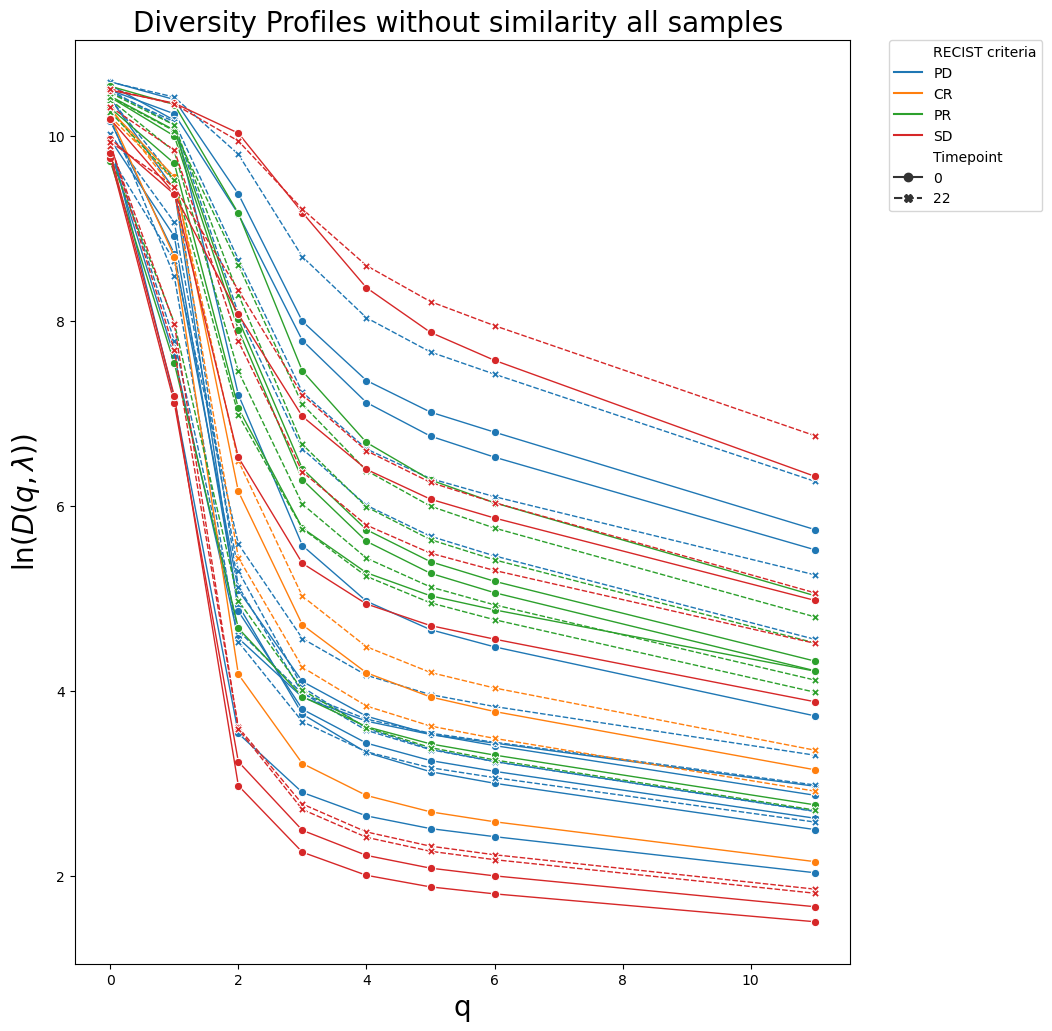

In [94]:
plt.figure(figsize=(10,12))
sns.color_palette("colorblind")
ax =sns.lineplot(data=divP_identity_plt_df, x="q", y="qDZ", hue="RECIST criteria", style="Timepoint", units="sample_name", markers=True, estimator = None, lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("q", fontsize = 20)
plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
plt.title("Diversity Profiles without similarity all samples ", fontsize = 20)
plt.savefig(wdir_path + "Diversity_profiles_ID_all_samples.png", bbox_inches='tight')
plt.show()
plt.close()
    



## All samples
### important features corrplot

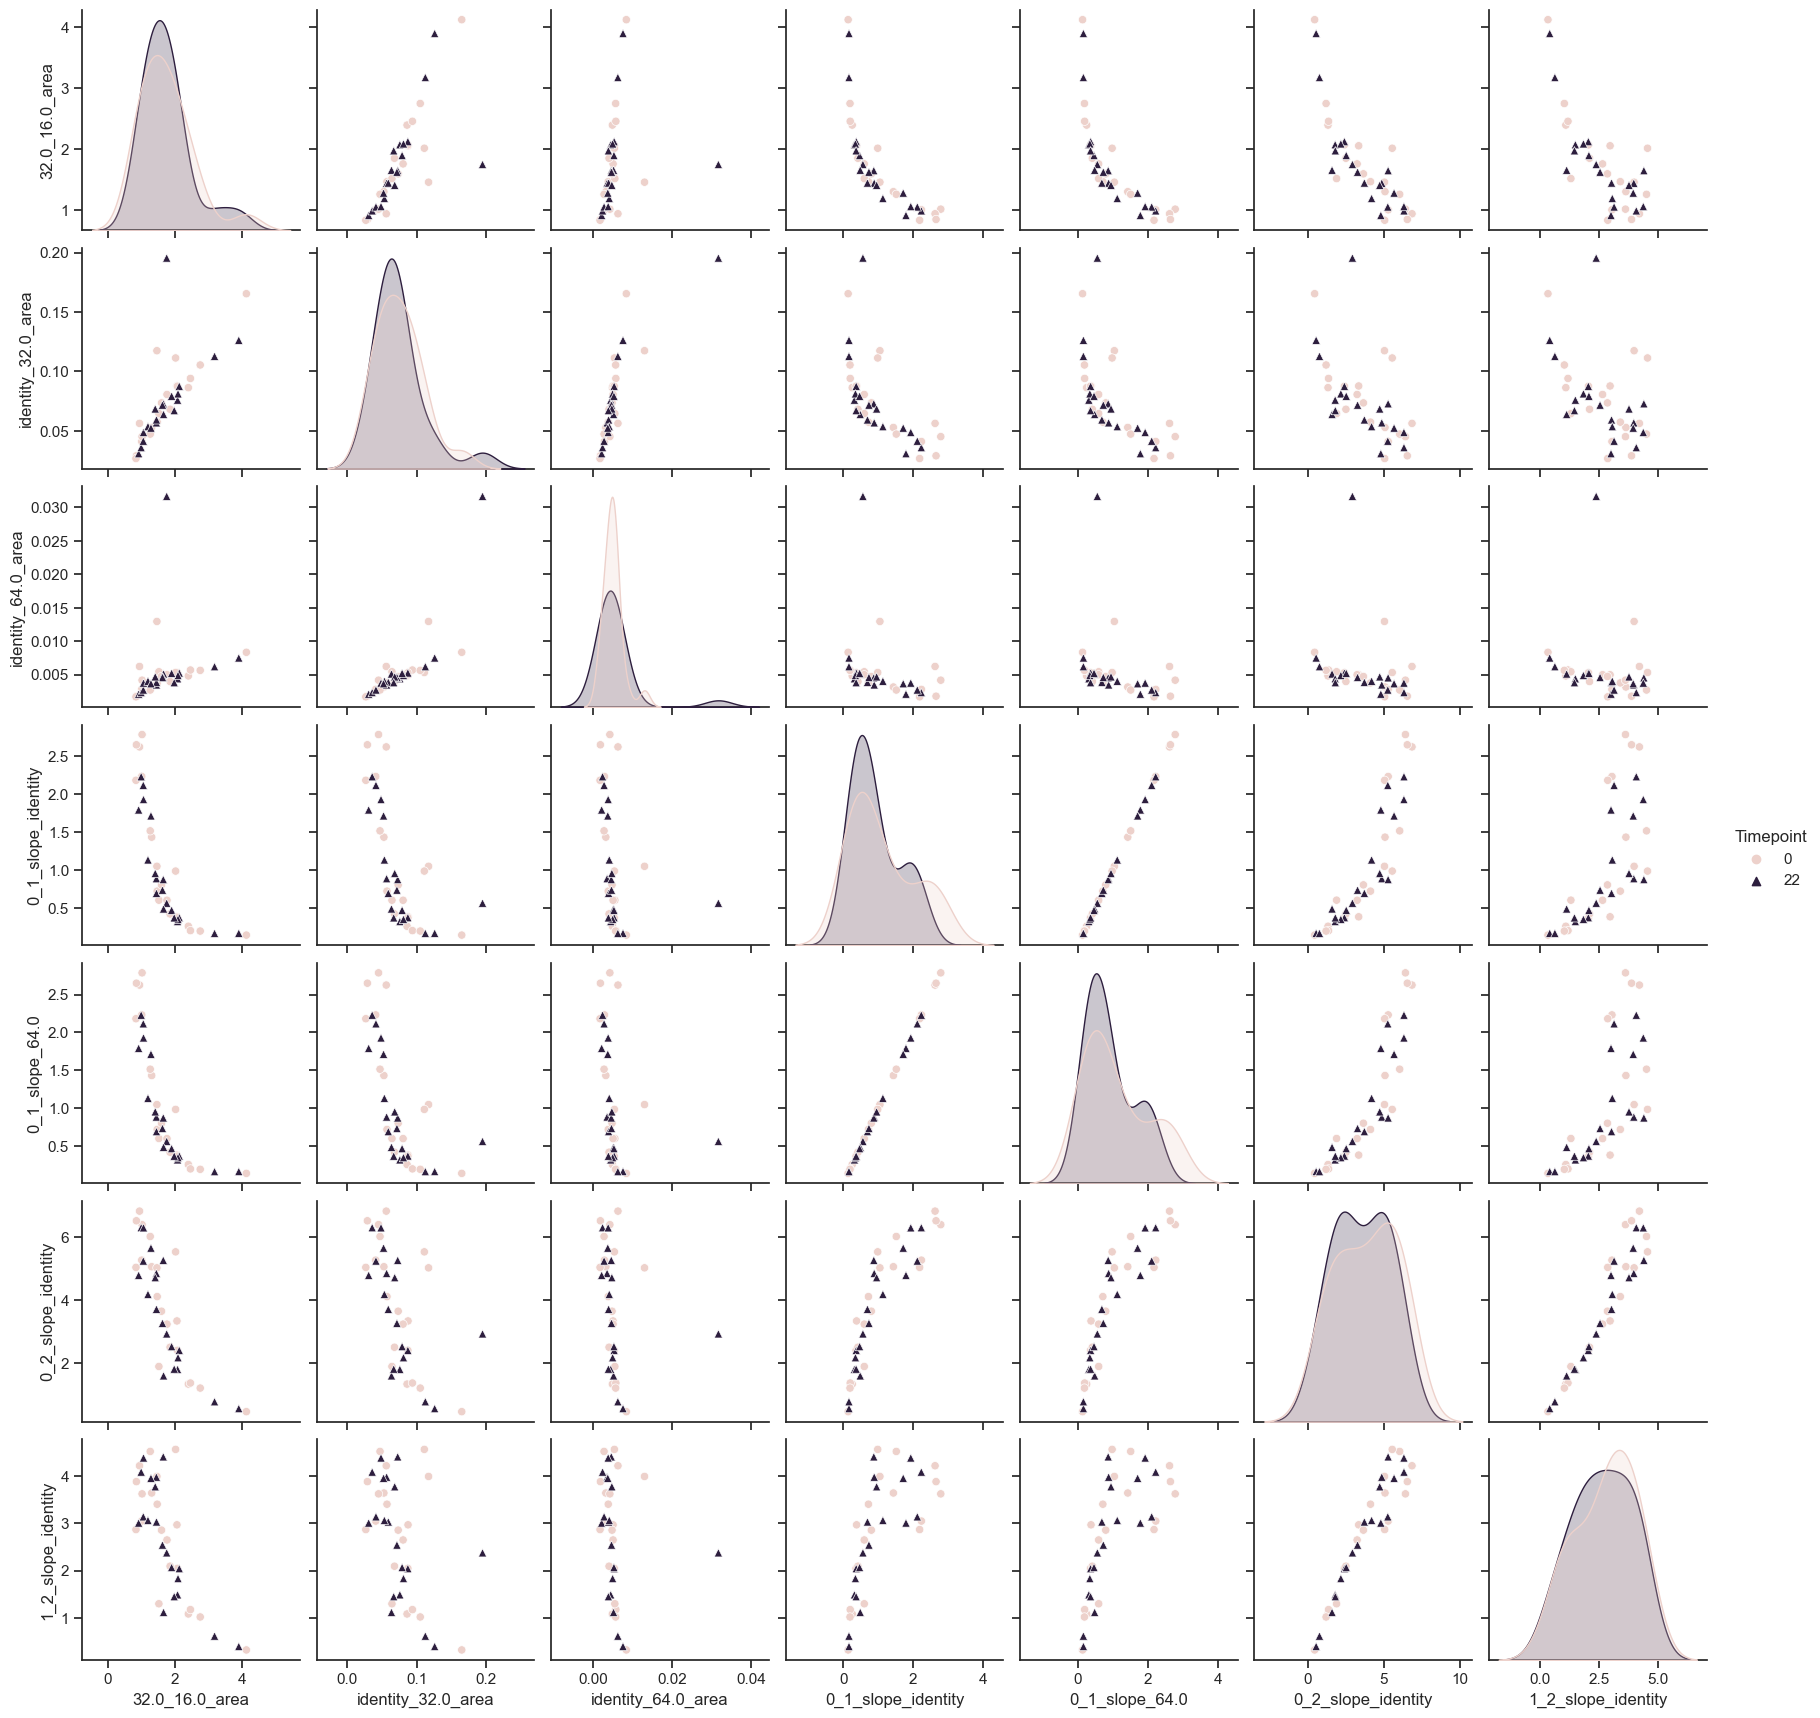

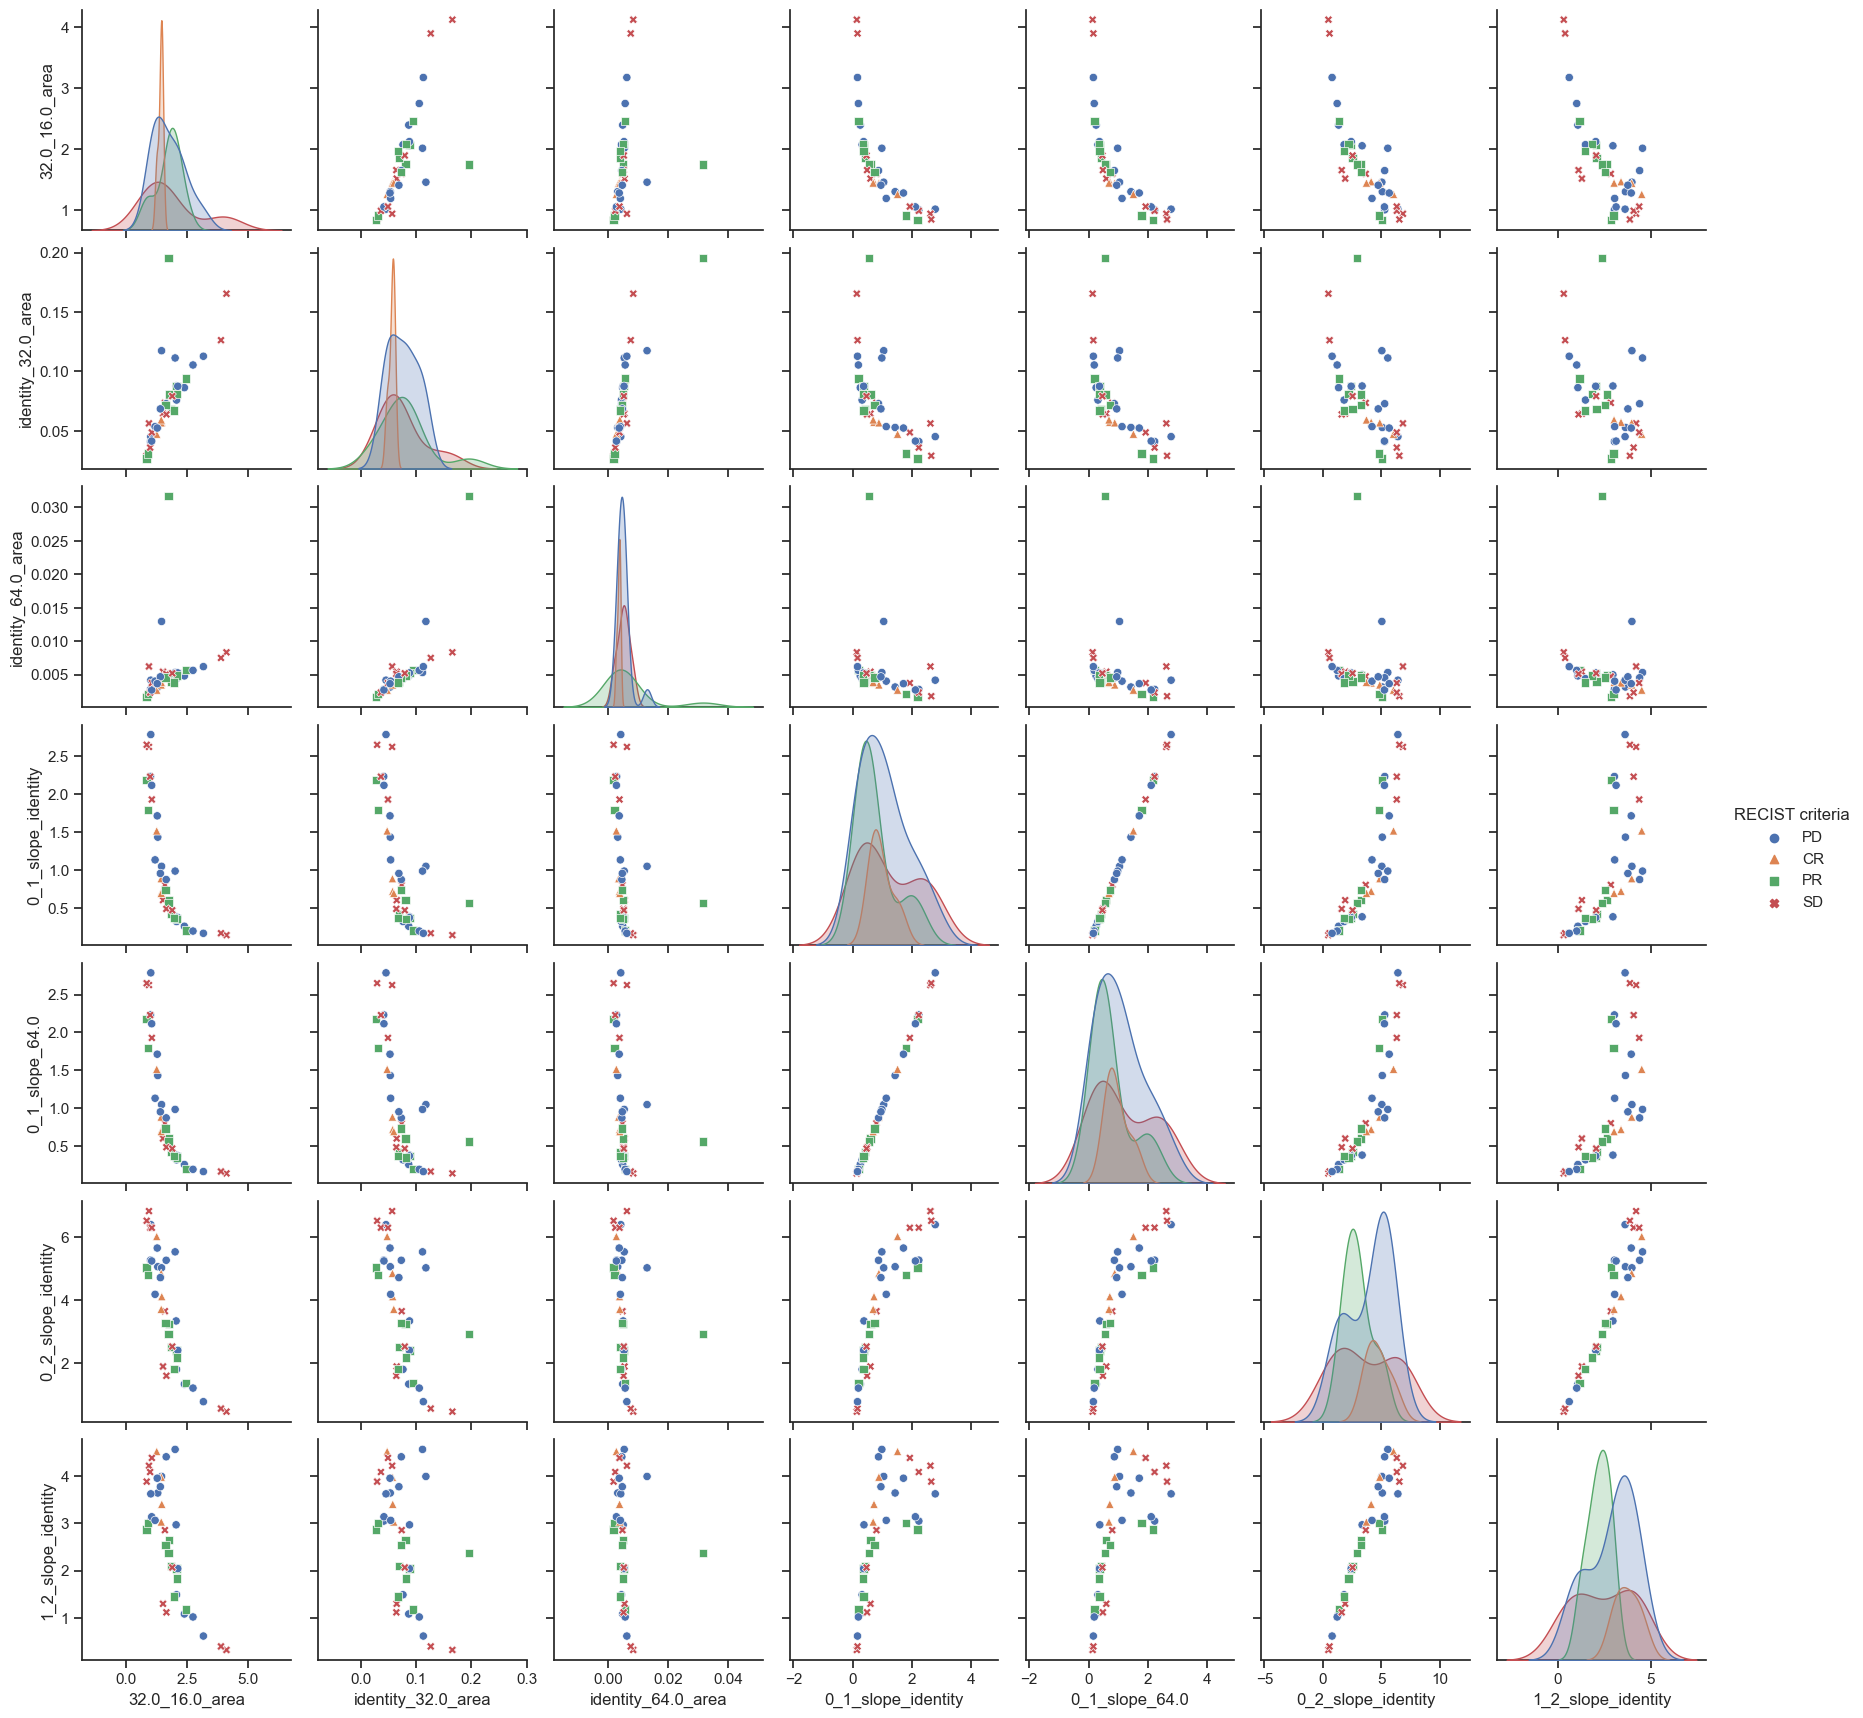

In [95]:
all_features = divP_features.copy()
important_ft = ["32.0_16.0_area", 
                "identity_32.0_area",
                "identity_64.0_area", 
                "0_1_slope_identity", 
                "0_1_slope_64.0", 
                "0_2_slope_identity", 
                "1_2_slope_identity",  
                "RECIST criteria", 
               "Timepoint"]
divP_impr_ft = divP_features[important_ft]

sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Timepoint", markers = ["o", "^"])
pairplot.savefig(wdir_path + "features_pairplot_timepoint.pdf")
pairplot

divP_impr_ft = divP_impr_ft.drop(['Timepoint'], axis=1)
sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="RECIST criteria", markers = ["o", "^", "s", "X"])
pairplot.savefig(wdir_path + "features_pairplot_RECIST.pdf")
pairplot


### Selected features scatterplot 

In [96]:
def plot_selected_ft_scatterplot(ft1, ft2, hue_cat, style_cat, xlabel_f1, ylabel_ft2, wdir_path, divP_features_df, legend_opt = True):
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = sns.color_palette("colorblind", len(list(set(divP_features_df[hue_cat]))))
    p = sns.scatterplot(x=ft1, y=ft2, 
                     data=divP_features_df,
                     hue=hue_cat, palette=cmap,  
                     style = style_cat, 
                     s = 140, legend = legend_opt
                     )
    if legend_opt:
        p.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize = 20, rotation=45)
    plt.yticks(fontsize = 20)
    plt.xlabel(xlabel_f1, fontsize = 26)
    plt.ylabel(ylabel_ft2, fontsize = 26)
    plt.tight_layout()
    if not os.path.isdir(wdir_path):
        os.makedirs(wdir_path, exist_ok=False)
    plt.savefig(wdir_path  + ft1 + "_" + ft2 + "_scatterplot_w_legend"+ str(legend_opt)+ ".pdf")
    plt.show()
    plt.close()


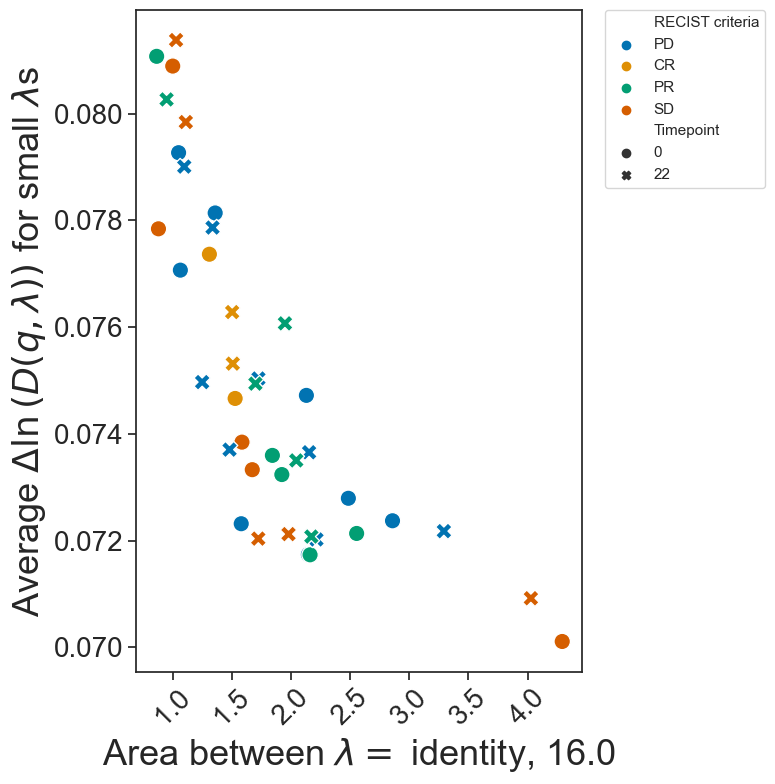

In [97]:
# delta lambda vs ID 16 area
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "RECIST criteria", "Timepoint", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, True)


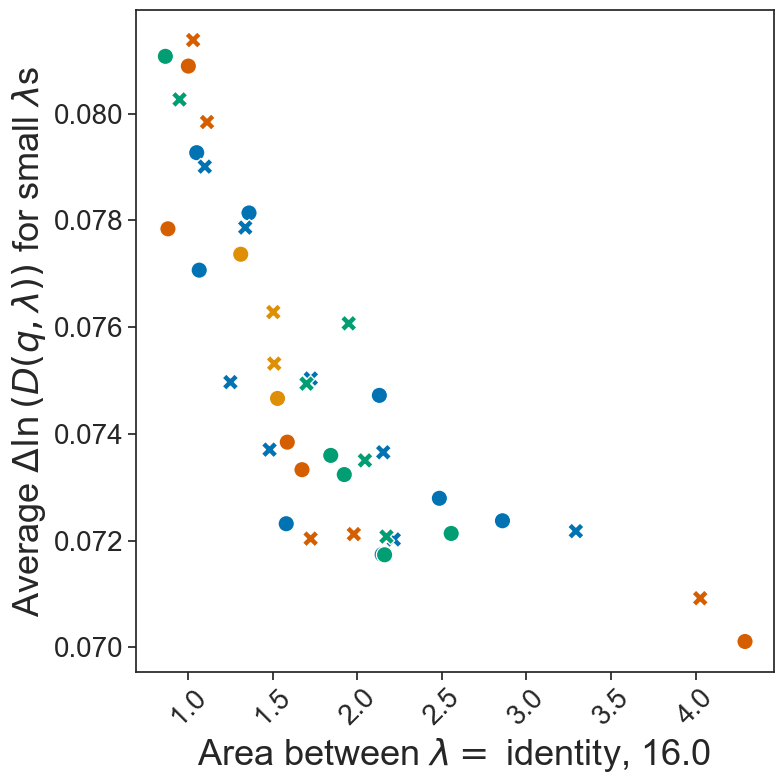

In [98]:
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                                        "RECIST criteria", "Timepoint",
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


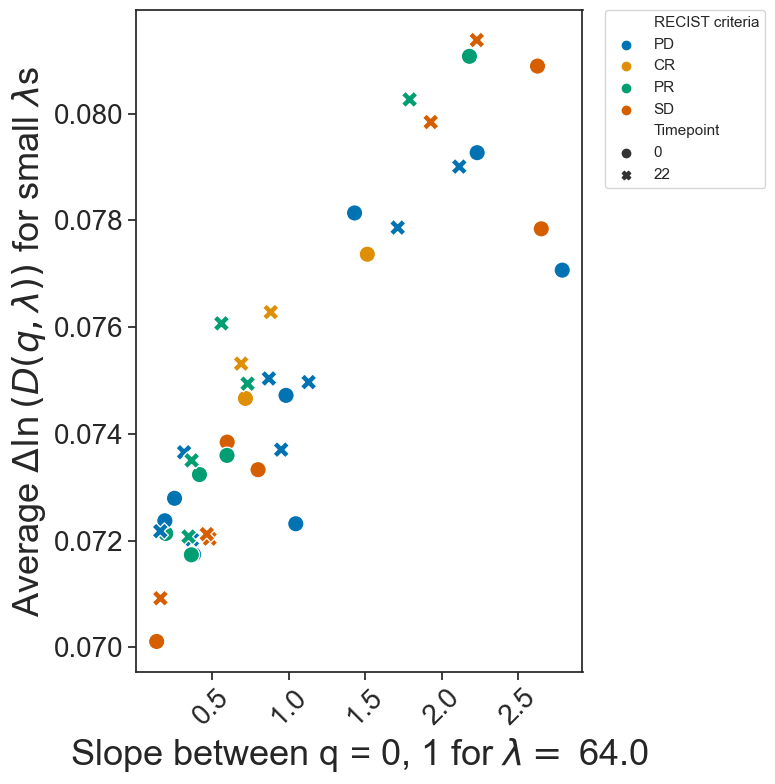

In [99]:
# delta lambda vs 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features)


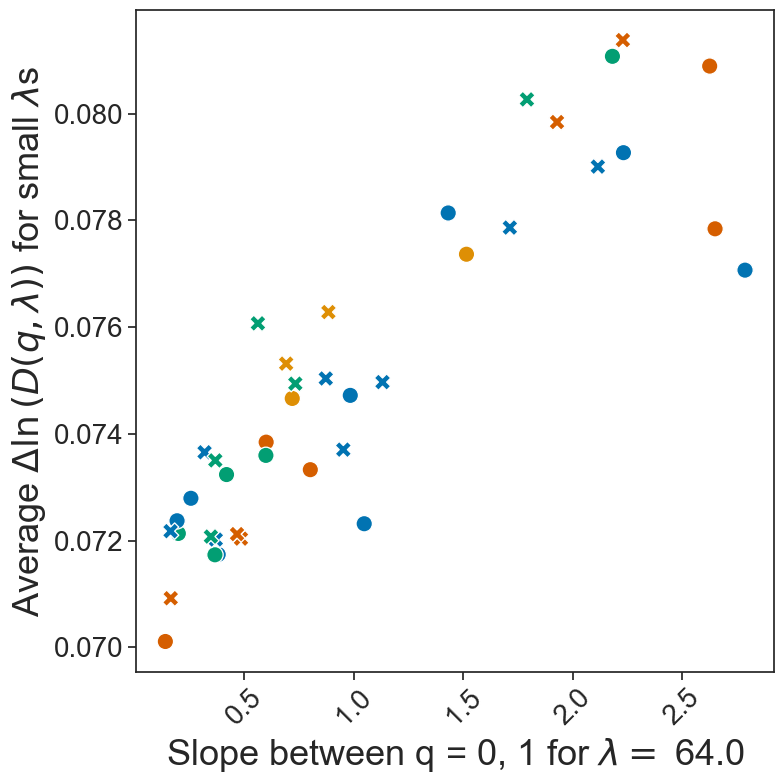

In [100]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


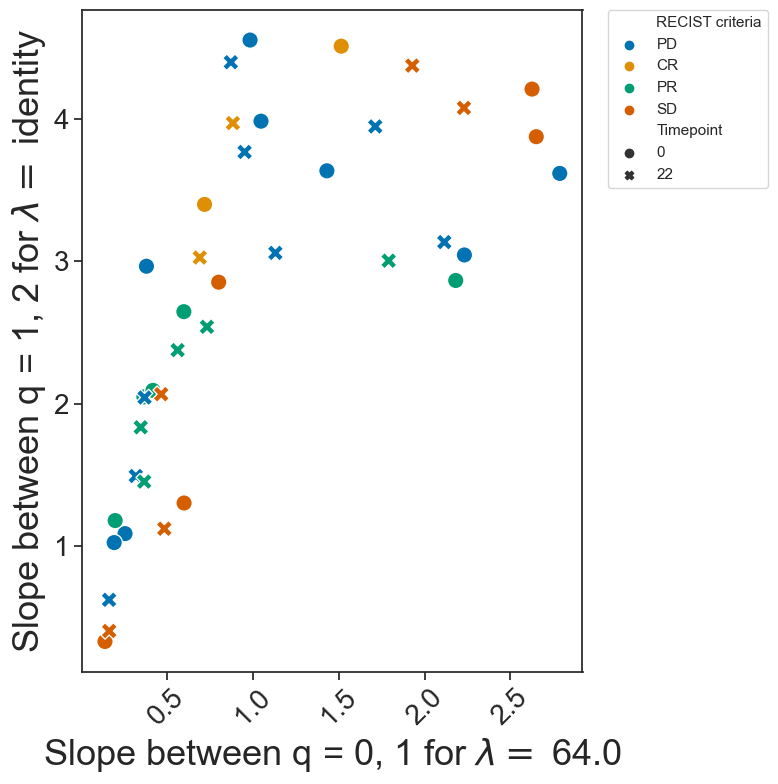

In [101]:
# 1-2 slope ID 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

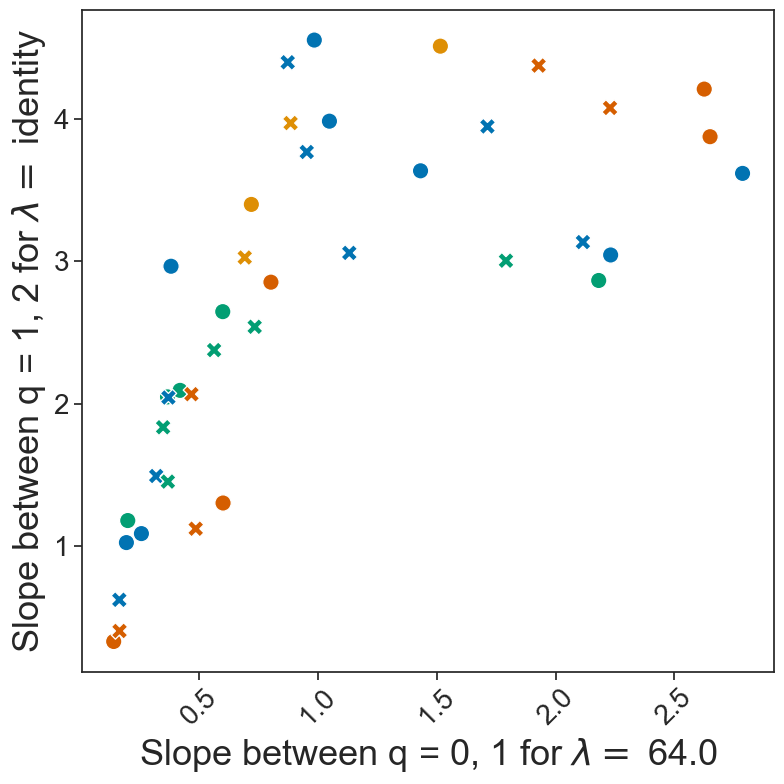

In [102]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

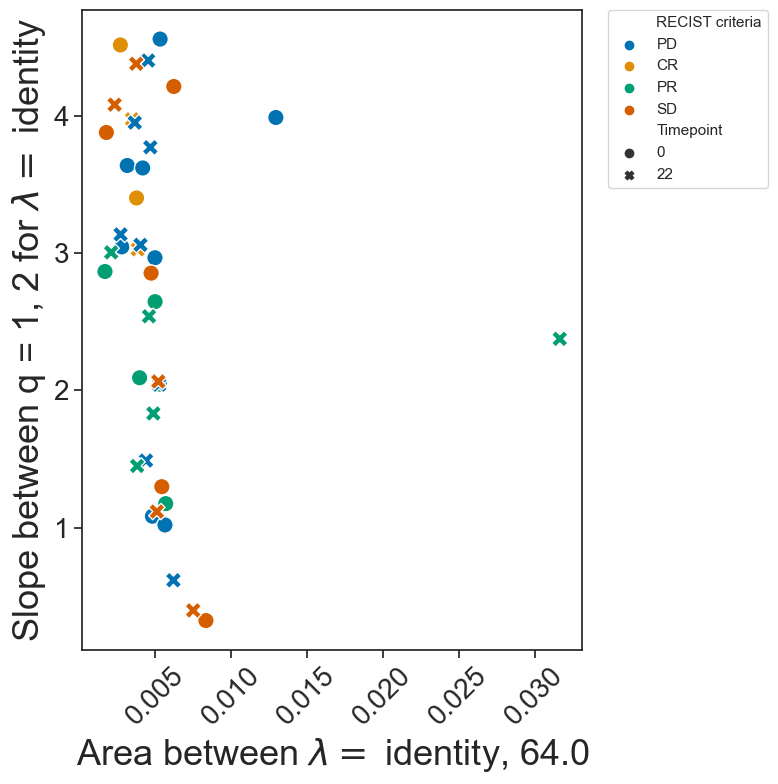

In [103]:
# 1-2 slope ID  ID 64 area

plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "RECIST criteria", "Timepoint", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

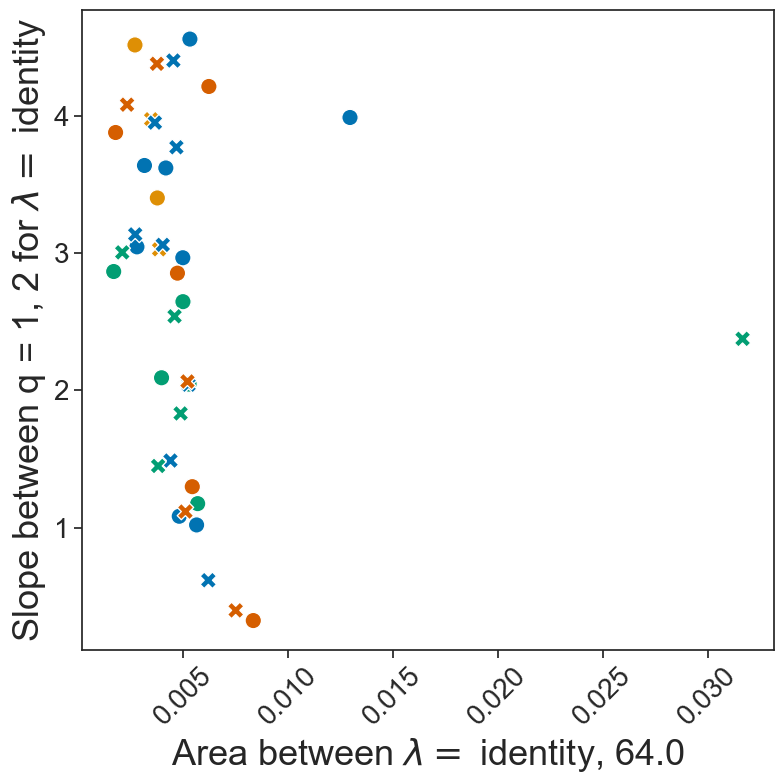

In [104]:
plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

### Lineplot of areas and slope 


In [105]:
hm_ft_df =divP_features[["sample_name", "RECIST criteria", "Timepoint" ,"Average area for small lambdas","identity_16.0_area","0_1_slope_identity"]]

hm_ft_df["sample_name"] = [" ".join([row["RECIST criteria"], " ", str(row["Timepoint"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
hm_ft_df["Regime"] = [" ".join([row["RECIST criteria"], " Day ", str(row["Timepoint"])]) for index,row in hm_ft_df.iterrows()]
#hm_ft_df = hm_ft_df.set_index("sample_name")
hm_ft_df = hm_ft_df.sort_values(by=['Timepoint', "RECIST criteria"])
hm_ft_df


/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50455/135717014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["sample_name"] = [" ".join([row["RECIST criteria"], " ", str(row["Timepoint"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50455/135717014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["Regime"] = [" ".join([row["RECIST criteria"], " Day ", str(row["Timepoint"])]) for index,row in

sample_name RECIST criteria  Timepoint  \
2      CR   0   Pt3_CR_PBMC_Day0              CR          0   
8      CR   0   Pt4_CR_PBMC_Day0              CR          0   
0     PD   0   Pt27_PD_PBMC_Day0              PD          0   
1     PD   0   Pt38_PD_PBMC_Day0              PD          0   
3     PD   0   Pt16_PD_PBMC_Day0              PD          0   
4     PD   0   Pt28_PD_PBMC_Day0              PD          0   
6     PD   0   Pt40_PD_PBMC_Day0              PD          0   
14    PD   0   Pt36_PD_PBMC_Day0              PD          0   
18    PD   0   Pt43_PD_PBMC_Day0              PD          0   
19    PD   0   Pt10_PD_PBMC_Day0              PD          0   
5     PR   0   Pt17_PR_PBMC_Day0              PR          0   
11    PR   0   Pt23_PR_PBMC_Day0              PR          0   
12    PR   0   Pt37_PR_PBMC_Day0              PR          0   
13    PR   0   Pt44_PR_PBMC_Day0              PR          0   
16     PR   0   Pt1_PR_PBMC_Day0              PR          0   
7     SD   0   Pt32_SD_PBMC_Day0              SD          0   
9      SD   0   Pt9_SD_PBMC_Day0              SD          0   
10    SD   0   Pt30_SD_PBMC_Day0              SD          0   
15    SD   0   Pt22_SD_PBMC_Day0              SD          0   
17     SD   0   Pt5_SD_PBMC_Day0              SD          0   
25   CR   22   Pt4_CR_PBMC_Day22              CR         22   
30   CR   22   Pt3_CR_PBMC_Day22              CR         22   
23  PD   22   Pt28_PD_PBMC_Day22              PD         22   
24  PD   22   Pt16_PD_PBMC_Day22              PD         22   
27  PD   22   Pt43_PD_PBMC_Day22              PD         22   
29  PD   22   Pt10_PD_PBMC_Day22              PD         22   
31  PD   22   Pt38_PD_PBMC_Day22              PD         22   
34  PD   22   Pt27_PD_PBMC_Day22              PD         22   
36  PD   22   Pt36_PD_PBMC_Day22              PD         22   
38  PD   22   Pt40_PD_PBMC_Day22              PD         22   
21  PR   22   Pt17_PR_PBMC_Day22              PR         22   
26  PR   22   Pt23_PR_PBMC_Day22              PR         22   
32  PR   22   Pt37_PR_PBMC_Day22              PR         22   
35  PR   22   Pt44_PR_PBMC_Day22              PR         22   
39   PR   22   Pt1_PR_PBMC_Day22              PR         22   
20   SD   22   Pt5_SD_PBMC_Day22              SD         22   
22   SD   22   Pt9_SD_PBMC_Day22              SD         22   
28  SD   22   Pt30_SD_PBMC_Day22              SD         22   
33  SD   22   Pt32_SD_PBMC_Day22              SD         22   
37  SD   22   Pt22_SD_PBMC_Day22              SD         22   

    Average area for small lambdas  identity_16.0_area  0_1_slope_identity  \
2                         0.074663            1.527558            0.719397   
8                         0.077366            1.309931            1.515650   
0                         0.078140            1.358875            1.432430   
1                         0.079270            1.049624            2.233429   
3                         0.072792            2.484636            0.255893   
4                         0.071739            2.146448            0.380643   
6                         0.077068            1.064425            2.787176   
14                        0.072315            1.579020            1.047448   
18                        0.074721            2.129804            0.984461   
19                        0.072371            2.857821            0.192546   
5                         0.072133            2.554675            0.198410   
11                        0.081076            0.864155            2.182982   
12                        0.071733            2.160879            0.366057   
13                        0.073596            1.842356            0.599106   
16                        0.073237            1.922304            0.418837   
7                         0.080893            1.000032            2.624170   
9                         0.073844            1.585211            0.600317   
10                        0.07784

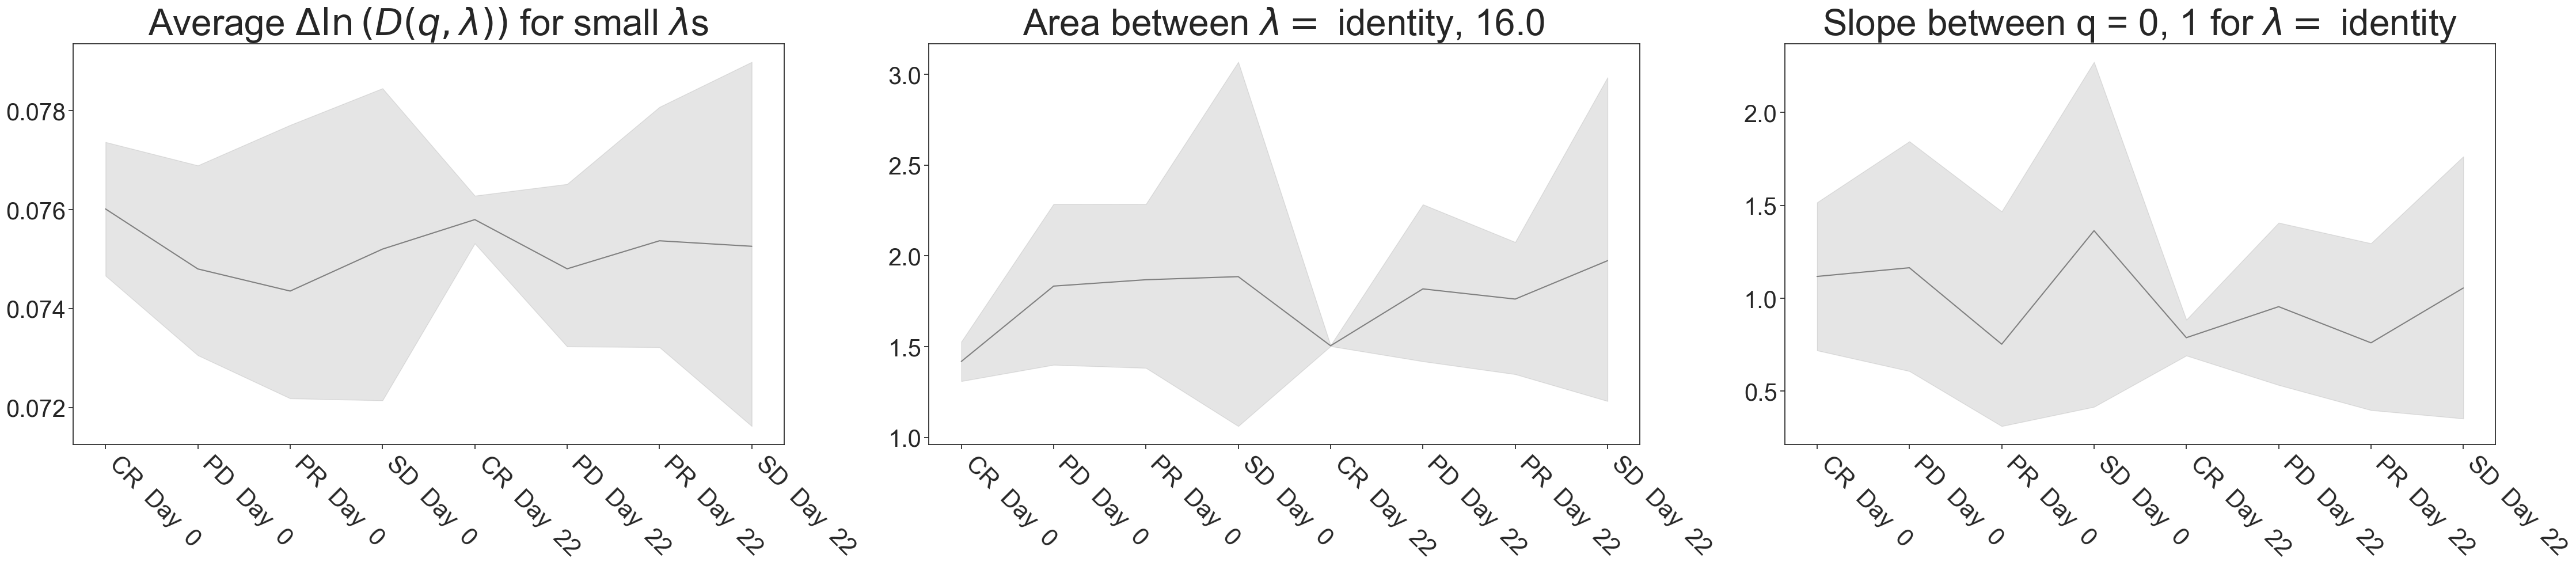

In [106]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 3, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Regime", y="Average area for small lambdas", data=hm_ft_df, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Regime", y="identity_16.0_area", data=hm_ft_df, sort=False, ax=ax[1], color = "gray")
p3 = sns.lineplot(x="Regime", y="0_1_slope_identity", data=hm_ft_df, sort=False, ax=ax[2], color = "gray")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path + "lineplot_areas_slope.pdf")

### PCA on features 

In [107]:
post_imm_time_df = divP_features["Timepoint"]
treatment_df = divP_features["RECIST criteria"]
sample_names_df = divP_features["sample_name"]

In [108]:
divP_features_treatment_time = divP_features.copy()
divP_features_treatment_time = divP_features.drop(["sample_name",
                                                   "patient",
                                                    "sample_type", 
                                                    "unique_CDR3s"], axis=1)

divP_features_treatment_time

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.003154            0.052764            1.358875   
1             0.002795            0.040914            1.049624   
2             0.003767            0.057244            1.527558   
3             0.004811            0.086275            2.484636   
4             0.004981            0.087676            2.146448   
5             0.005690            0.094025            2.554675   
6             0.004172            0.045051            1.064425   
7             0.006223            0.056192            1.000032   
8             0.002701            0.047180            1.309931   
9             0.005433            0.064419            1.585211   
10            0.001779            0.028917            0.879466   
11            0.001688            0.026617            0.864155   
12            0.005280            0.087440            2.160879   
13            0.004988            0.080530            1.842356   
14            0.012950            0.117370            1.579020   
15            0.004726            0.073446            1.672339   
16            0.003969            0.068071            1.922304   
17            0.008340            0.165351            4.292394   
18            0.005319            0.111252            2.129804   
19            0.005639            0.105352            2.857821   
20            0.007502            0.126206            4.027446   
21            0.031658            0.195414            1.948471   
22            0.005107            0.063750            1.723358   
23            0.005256            0.087447            2.215070   
24            0.004393            0.075845            2.152773   
25            0.003474            0.056711            1.502618   
26            0.002096            0.030749            0.948064   
27            0.004532            0.072749            1.724429   
28            0.002325            0.035830            1.028368   
29            0.006197            0.112708            3.291892   
30            0.003852            0.059167            1.507901   
31            0.002713            0.041293            1.097490   
32            0.004876            0.081102            2.171739   
33            0.003749            0.048608            1.110679   
34            0.004027            0.053487            1.248906   
35            0.004588            0.071628            1.698957   
36            0.004677            0.068403            1.480501   
37            0.005203            0.079115            1.978866   
38            0.003651            0.052283            1.336555   
39            0.003805            0.066967            2.044456   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0            6.302410          14.920070          24.401665   
1            5.241175          13.134423          22.329857   
2            7.852819          19.231063          28.749971   
3           18.868373          36.007252          45.522476   
4           10.377730          25.018785          34.297884   
5           17.263229          34.324567          43.765365   
6            5.008369          10.169219          16.980521   
7            4.740312           8.691892          13.719442   
8            6.086245          12.256709          19.947123   
9           13.402917          30.448930          40.029429   
10           4.618687           9.127832          14.880077   
11           4.885813          12.493838          21.678471   
12          12.523683          28.938955          38.270639   
13           9.801190          25.341119          34.816798   
14           6.872415          14.850248          23.365669   
15           8.787075          23.034025          32.422907   
16          11.538427          27.801274          37.335864   
17          26.162466          42.856371          52.058958   
18           8.364247          15.915500          24.235412   
19          20.562204          37.617

In [109]:
divP_features_treatment_time.shape

(40, 187)

In [110]:
observables = [col for col in list(divP_features_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x = divP_features_treatment_time.loc[:, observables].values
# Separating out the target
y = divP_features_treatment_time.loc[:,'RECIST criteria'].values

In [111]:
x.shape

(40, 185)

In [112]:
x.mean(), x.std()

(13.681104186233258, 16.55519314180159)

In [113]:
x_scaled = StandardScaler().fit_transform(x)

In [114]:
x_scaled.mean(), x_scaled.std()

(6.769359847444198e-17, 1.0)

In [115]:
pca_scaled = decomposition.PCA(n_components=26)
principalComponents_scaled = pca_scaled.fit_transform(x_scaled)

principalDf_scaled = pd.DataFrame(data = principalComponents_scaled)
principalDf_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_scaled)]
finalDf_scaled = pd.concat([principalDf_scaled, divP_features_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



In [116]:
def plotPCA(pca_scaled, colour_category, style_category, final_Df, wdir_path, fig_name, legend):
    """
    INPUT:  pca_scaled: pca object
            colour_category: string denoting a categorical var to colour by
            style_category: string denoting a categorical var for the point shape 
            final_Df: DataFrame with principal components and categorical variables
            wdir_path: path to working directory
            fig_name: string for figure name, ending with the extension pdf or png
            legend: True or False
            
    OUTPUT: 
            PCA figure with the aspect ratio corresponding to the principal components values 
    """
    per_PC1 = int(round(pca_scaled.explained_variance_ratio_[0]*100, 0))
    per_PC2 = int(round(pca_scaled.explained_variance_ratio_[1]*100, 0))
    if per_PC1 != 0 and per_PC2 != 0:
        fig, ax = plt.subplots(figsize=(per_PC1/5,per_PC2/5))
    else: 
        fig, ax = plt.subplots(figsize=(20,1))
    cmap = sns.color_palette("colorblind", len(list(set(final_Df[colour_category]))))
    if legend == True: 
        legend_box = "full"
    else: 
        legend_box = False
    p = sns.scatterplot(x="PC_0", y="PC_1",
                     hue=colour_category, style = style_category,
                     palette=cmap, s=100,
                     data=final_Df, 
                     alpha = 1, legend = legend_box)
    if legend == True: 
        p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(axis='both',          # changes apply which axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left = False,
                    right = False,
                    labelbottom=False,
                    labelleft = False) # labels along the bottom edge are off
    #plt.xticks(fontsize = 13)
    #plt.yticks(fontsize = 13)
    plt.xlabel("".join(["PC1 (",str(per_PC1),"%)"]), fontsize = 15)
    plt.ylabel("".join(["PC2 (",str(per_PC2),"%)"]), fontsize = 15)
    plt.tight_layout()
    plt.savefig(wdir_path + fig_name, bbox_inches='tight')

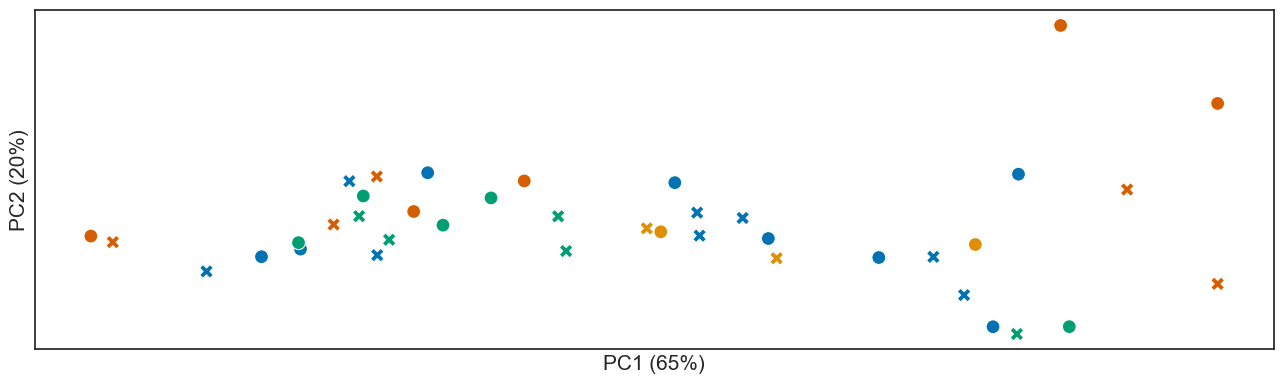

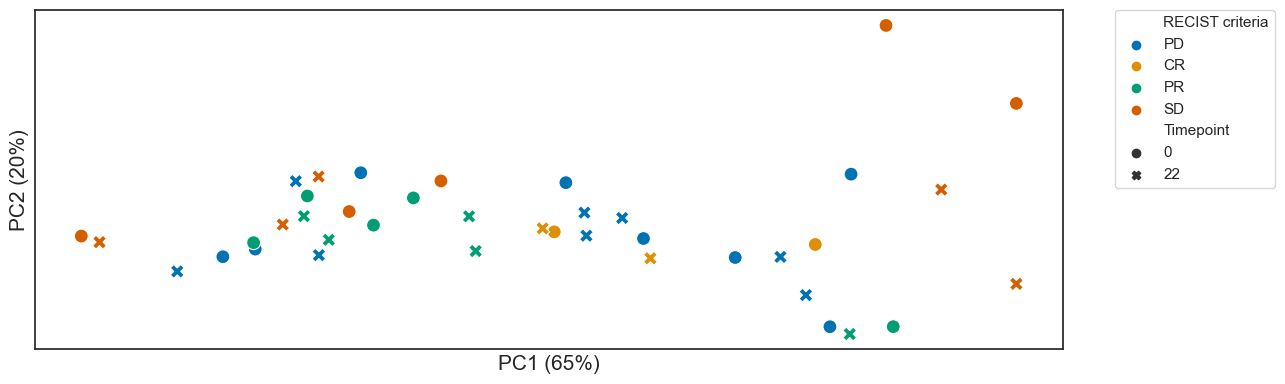

In [117]:
plotPCA(pca_scaled, "RECIST criteria", "Timepoint", 
        finalDf_scaled, wdir_path, "PCA_features.pdf", False)


plotPCA(pca_scaled,  "RECIST criteria", "Timepoint", 
        finalDf_scaled, wdir_path, "PCA_features_w_legend.pdf", True)




### PCA on $D(q,\lambda)$

In [118]:
post_imm_time_divP1_all_df = divP1_all_df["Timepoint"]
treatment_divP1_all_df = divP1_all_df["RECIST criteria"]
sample_names_divP1_all_df = divP1_all_df["sample_name"]

In [119]:

divP1_all_df_treatment_time = divP1_all_df.copy()
divP1_all_df_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "patient", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                ], axis=1)
divP1_all_df_treatment_time

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.080324  0.080305  0.080286  0.080267  0.080248  0.080229  0.080211   
1    0.08131    0.0813  0.081289  0.081279  0.081268  0.081258  0.081247   
2   0.076677  0.076659  0.076641  0.076623  0.076606  0.076588   0.07657   
3   0.074625  0.074609  0.074593  0.074576   0.07456  0.074544  0.074528   
4   0.073666  0.073645  0.073623  0.073601   0.07358  0.073559  0.073538   
5   0.073927  0.073911  0.073896   0.07388  0.073864  0.073849  0.073833   
6   0.079482  0.079467  0.079452  0.079437  0.079421  0.079406  0.079391   
7   0.083516  0.083502  0.083489  0.083475  0.083462  0.083448  0.083435   
8   0.079534  0.079521  0.079508  0.079494  0.079481  0.079468  0.079455   
9   0.075801  0.075779  0.075757  0.075736  0.075714  0.075693  0.075672   
10  0.080873  0.080847  0.080821  0.080794  0.080768  0.080742  0.080715   
11  0.083094  0.083081  0.083068  0.083055  0.083042  0.083029  0.083017   
12  0.073693  0.073673  0.073653  0.073633  0.073614  0.073594  0.073575   
13  0.075603  0.075581  0.075559  0.075537  0.075516  0.075494  0.075473   
14  0.074545  0.074528  0.074511  0.074494  0.074477   0.07446  0.074443   
15  0.075521  0.075498  0.075475  0.075452  0.075429  0.075406  0.075384   
16   0.07517  0.075151  0.075133  0.075114  0.075096  0.075077  0.075059   
17  0.071877  0.071863  0.071849  0.071834   0.07182  0.071806  0.071792   
18  0.076792  0.076778  0.076765  0.076751  0.076737  0.076723   0.07671   
19  0.074148  0.074133  0.074119  0.074104  0.074089  0.074074   0.07406   
20  0.072712  0.072696  0.072681  0.072666  0.072651  0.072636  0.072621   
21  0.078068  0.078048  0.078029  0.078009  0.077989   0.07797   0.07795   
22  0.073914  0.073896  0.073879  0.073862  0.073844  0.073827   0.07381   
23  0.073976  0.073953  0.073931  0.073909  0.073888  0.073866  0.073844   
24  0.075472  0.075455  0.075439  0.075422  0.075406  0.075389  0.075373   
25  0.078242  0.078225  0.078209  0.078192  0.078176  0.078159  0.078143   
26  0.082234  0.082222   0.08221  0.082198  0.082186  0.082174  0.082162   
27  0.077082  0.077062  0.077043  0.077024  0.077005  0.076986  0.076967   
28  0.083537  0.083529  0.083521  0.083513  0.083505  0.083497  0.083489   
29  0.073975  0.073961  0.073948  0.073934  0.073921  0.073908  0.073895   
30  0.077335  0.077315  0.077295  0.077274  0.077254  0.077234  0.077214   
31   0.08115  0.081136  0.081122  0.081107  0.081093  0.081079  0.081065   
32  0.073942  0.073924  0.073906  0.073888   0.07387  0.073852  0.073835   
33  0.082048  0.082032  0.082016     0.082  0.081984  0.081969  0.081954   
34  0.077018     0.077  0.076983  0.076965  0.076947   0.07693  0.076912   
35  0.076997  0.076975  0.076954  0.076932  0.076911  0.076889  0.076868   
36  0.075809  0.075791  0.075774  0.075757  0.075739  0.075722  0.075705   
37  0.074093   0.07407  0.074048  0.074025  0.074003  0.073981  0.073959   
38   0.08008  0.080064  0.080047  0.080031  0.080015  0.079998  0.079982   
39  0.075392  0.075374  0.075356  0.075338   0.07532  0.075302  0.075285   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_0 L_identity_q_1  \
0     0.06773  0.160479  0.160403  ...      10.159989       8.727558   
1    0.069459   0.16241  0.162368  ...       9.849137       7.615708   
2    0.064366  0.153242  0.153169  ...      10.277634       9.558237   
3    0.063342  0.149154  0.149089  ...      10.494325      10.238432   
4    0.062188  0.147238   0.14715  ...      10.549307      10.168664   
5    0.062864  0.147761  0.147697  ...      10.537362      10.338952   
6    0.066798  0.158657  0.158593  ...       9.947744       7.160568   
7    0.076447  0.166473  0.166414  ...       9.813946       7.189775   
8    0.067322  0.158829  0.158776  ...      10.211303       8.695653   
9    0.064115  0.151506  0.151418  ...        9.96979       9.369473   
10   0.066612  0.161396  0.161286  ...       9.765546       7.113448   
11   0.071606  0.16598

In [120]:
divP1_all_df_treatment_time.shape

(40, 130)

In [121]:
observables = [col for col in list(divP1_all_df_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x_qDZ = divP1_all_df_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ = divP1_all_df_treatment_time.loc[:,'RECIST criteria'].values

In [122]:
x_qDZ.shape

(40, 128)

In [123]:
x_qDZ.mean(), x_qDZ.std()

(2.2784151720349746, 2.7676772388345263)

In [124]:
x_qDZ_scaled = StandardScaler().fit_transform(x_qDZ)

In [125]:
x_qDZ_scaled.mean(), x_qDZ_scaled.std()

(2.874436799693569e-16, 1.0)

In [126]:
pca_qDZ_scaled = decomposition.PCA(n_components=26)
principalComponents_qDZ_scaled = pca_qDZ_scaled.fit_transform(x_qDZ_scaled)

principalDf_qDZ_scaled = pd.DataFrame(data = principalComponents_qDZ_scaled)
principalDf_qDZ_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_scaled)]
finalDf_qDZ_scaled = pd.concat([principalDf_qDZ_scaled, divP1_all_df_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



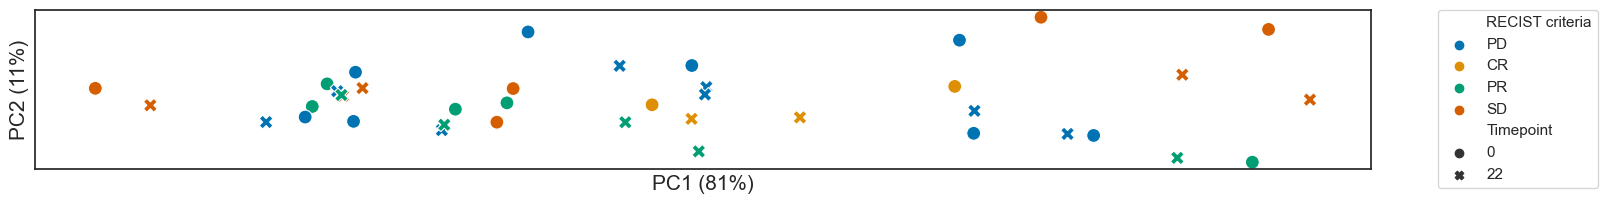

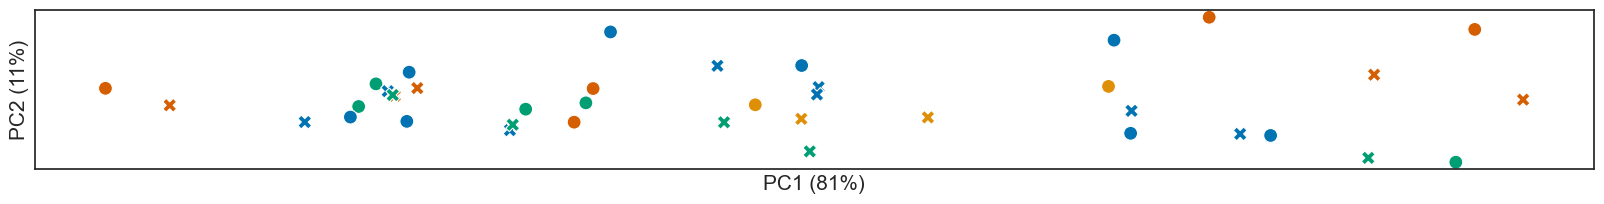

In [127]:
plotPCA(pca_qDZ_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ_w_legend.pdf", True)

plotPCA(pca_qDZ_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ.pdf", False)





### PCA on identity qD

In [128]:
col_without_identity = [colname for colname in list(divP1_all_df) if "L" in colname] 
col_without_identity = [colname for colname in col_without_identity if "identity" not in colname] 

In [129]:
divP1_identity_treatment_time = divP1_all_df.copy()
divP1_identity_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "patient", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                  ] + col_without_identity, axis=1)









divP1_identity_treatment_time



L_identity_q_0 L_identity_q_1 L_identity_q_2 L_identity_q_3 L_identity_q_4  \
0       10.159989       8.727558       5.089341       4.102155       3.727058   
1        9.849137       7.615708       4.570001       3.932038       3.673428   
2       10.277634       9.558237       6.156574       4.714467       4.196456   
3       10.494325      10.238432       9.154247       7.787608       7.117815   
4       10.549307      10.168664        7.20227       5.571519       4.969877   
5       10.537362      10.338952        9.16293        7.45807       6.686036   
6        9.947744       7.160568       3.540471       2.902386        2.64939   
7        9.813946       7.189775       2.976326       2.257046       2.007191   
8       10.211303       8.695653       4.179965        3.21559        2.87011   
9         9.96979       9.369473       8.069964       6.967117       6.395177   
10       9.765546       7.113448       3.235066       2.493419       2.222513   
11       9.726333       7.543351       4.677221       3.937796       3.613643   
12      10.428926      10.062869       8.016323       6.400979       5.742855   
13      10.301794       9.702688       7.056038       5.760191       5.277604   
14       9.962275       8.914827       4.927232       3.748846       3.335104   
15      10.181914       9.379648       6.525476       5.379384       4.940055   
16      10.417687        9.99885       7.906278       6.283189        5.61731   
17      10.493328       10.35412      10.029432       9.170964       8.358506   
18      10.404202       9.419741       4.861126       3.801696       3.435923   
19      10.585447      10.392902       9.371984       7.995076       7.355736   
20       10.50723      10.343483       9.944743       9.208395       8.597681   
21      10.392926       9.831398       7.455443       6.018776       5.435238   
22        9.93639       9.451248       8.332814        7.20052       6.596757   
23      10.491774      10.122079       8.079888       6.615168       6.006678   
24      10.471468      10.153175       8.663371       7.228472       6.615588   
25      10.299979       9.415312       5.440952       4.255795       3.836797   
26       9.772752       7.980428       4.974965       4.009538       3.604633   
27      10.403748        9.53108       5.128618       3.978036       3.574309   
28       9.917933       7.687092       3.606033       2.777311         2.4757   
29      10.581952       10.41926        9.80109       8.693103       8.033796   
30      10.207879       9.516257       6.488446       5.023523       4.477717   
31       9.904587       7.787821       4.651388       3.969251        3.69503   
32      10.464873      10.117495       8.284857       6.664041       5.990136   
33       9.895909       7.966227       3.587368       2.718921       2.417943   
34       9.781263       8.648809       5.588437       4.566276       4.169422   
35      10.258992        9.52534       6.985226       5.754523       5.238621   
36      10.019803       9.066394       5.295608       4.041302       3.596151   
37      10.313808       9.846737       7.781055       6.367313       5.792317   
38      10.193804       8.480017       4.529624       3.667519       3.341952   
39      10.421329      10.053914       8.603544       7.097853       6.382471   

   L_identity_q_5 L_identity_q_6 L_identity_q_11 RECIST criteria  Timepoint  
0        3.530642       3.409435        2.872453              PD          0  
1        3.529245       3.436158        2.970065              PD          0  
2        3.934828       3.777525        3.147951              CR          0  
3        6.754223       6.527052        5.526473              PD          0  
4        4.662281        4.47643        3.730535              PD          0  
5        6.281185       6.033733        5.029818              PR          0  
6        2.511903       2.424892        2.035004              PD          0  
7        1.881794       1.806526        1.505438         

In [130]:
observables = [col for col in list(divP1_identity_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x_qDZ_identity1 = divP1_identity_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ_identity1 = divP1_identity_treatment_time.loc[:,'RECIST criteria'].values

In [131]:
x_qDZ_identity1.shape

(40, 8)

In [132]:
x_qDZ_identity1.mean(), x_qDZ_identity1.std()

(6.104520444014398, 2.7078492004147323)

In [133]:
x_qDZ_identity1_scaled = StandardScaler().fit_transform(x_qDZ_identity1)

In [134]:
x_qDZ_identity1_scaled.mean(), x_qDZ_identity1_scaled.std()

(-2.6645352591003756e-16, 1.0)

In [135]:
pca_qDZ_identity1_scaled = decomposition.PCA(n_components=8)
principalComponents_qDZ_identity1_scaled = pca_qDZ_identity1_scaled.fit_transform(x_qDZ_identity1_scaled)

principalDf_qDZ_identity1_scaled = pd.DataFrame(data = principalComponents_qDZ_identity1_scaled)
principalDf_qDZ_identity1_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_identity1_scaled)]
finalDf_qDZ_identity1_scaled = pd.concat([principalDf_qDZ_identity1_scaled, divP1_identity_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



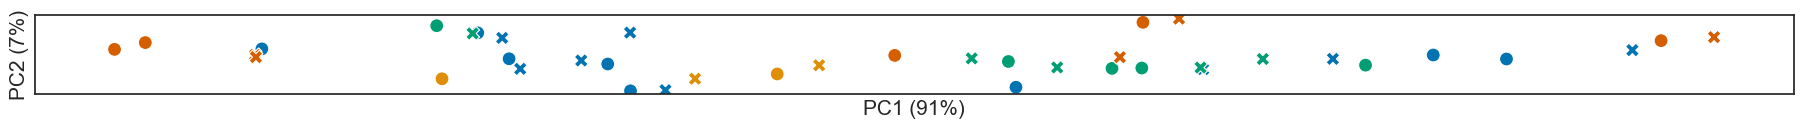

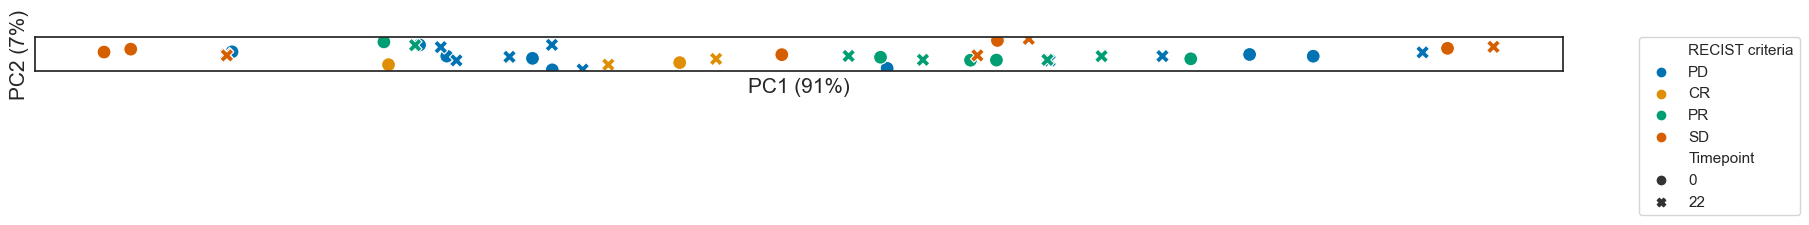

In [136]:
plotPCA(pca_qDZ_identity1_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity.pdf", False)

plotPCA(pca_qDZ_identity1_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity_w_legend.pdf", True)






### Exp(Shannon index) separation 

In [137]:
divP1_identity_q1_treatment_time = divP1_all_df[["L_identity_q_1", "Timepoint", "RECIST criteria"]]

divP1_identity_q1_treatment_time



L_identity_q_1  Timepoint RECIST criteria
0        8.727558          0              PD
1        7.615708          0              PD
2        9.558237          0              CR
3       10.238432          0              PD
4       10.168664          0              PD
5       10.338952          0              PR
6        7.160568          0              PD
7        7.189775          0              SD
8        8.695653          0              CR
9        9.369473          0              SD
10       7.113448          0              SD
11       7.543351          0              PR
12      10.062869          0              PR
13       9.702688          0              PR
14       8.914827          0              PD
15       9.379648          0              SD
16        9.99885          0              PR
17       10.35412          0              SD
18       9.419741          0              PD
19      10.392902          0              PD
20      10.343483         22              SD
21       9.831398         22              PR
22       9.451248         22              SD
23      10.122079         22              PD
24      10.153175         22              PD
25       9.415312         22              CR
26       7.980428         22              PR
27        9.53108         22              PD
28       7.687092         22              SD
29       10.41926         22              PD
30       9.516257         22              CR
31       7.787821         22              PD
32      10.117495         22              PR
33       7.966227         22              SD
34       8.648809         22              PD
35        9.52534         22              PR
36       9.066394         22              PD
37       9.846737         22              SD
38       8.480017         22              PD
39      10.053914         22              PR

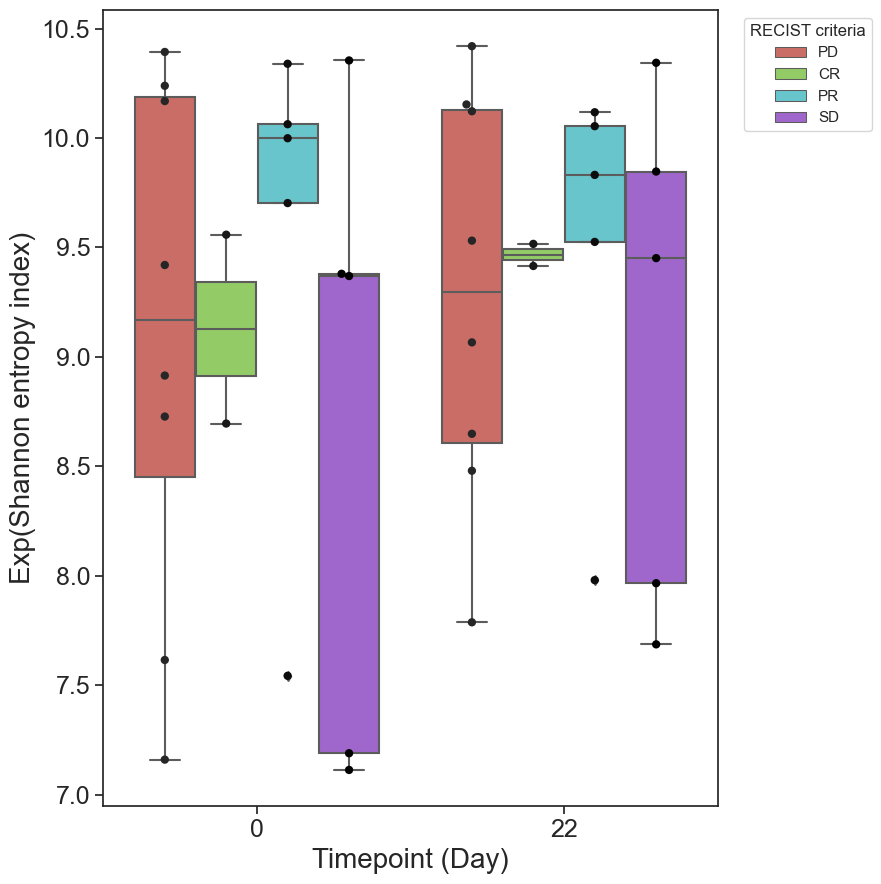

In [138]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"]))))
p = sns.boxplot(x="Timepoint", y="L_identity_q_1", hue="RECIST criteria",
                 data=divP1_identity_q1_treatment_time, palette=cmap)
p = sns.swarmplot(x="Timepoint", y="L_identity_q_1", hue="RECIST criteria",data=divP1_identity_q1_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)

# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"])))], labels[0:len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"])))], 
                   title = "RECIST criteria", loc=2, bbox_to_anchor=(1.03, 1))


plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Timepoint (Day)", fontsize = 20)
plt.ylabel("Exp(Shannon entropy index)", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Exp_Shannon_entropy_barplot.pdf")

### Gini analogue separation

In [139]:
divP1_identity_q2_treatment_time = divP1_all_df[["L_identity_q_2", "Timepoint", "RECIST criteria"]]

divP1_identity_q2_treatment_time



L_identity_q_2  Timepoint RECIST criteria
0        5.089341          0              PD
1        4.570001          0              PD
2        6.156574          0              CR
3        9.154247          0              PD
4         7.20227          0              PD
5         9.16293          0              PR
6        3.540471          0              PD
7        2.976326          0              SD
8        4.179965          0              CR
9        8.069964          0              SD
10       3.235066          0              SD
11       4.677221          0              PR
12       8.016323          0              PR
13       7.056038          0              PR
14       4.927232          0              PD
15       6.525476          0              SD
16       7.906278          0              PR
17      10.029432          0              SD
18       4.861126          0              PD
19       9.371984          0              PD
20       9.944743         22              SD
21       7.455443         22              PR
22       8.332814         22              SD
23       8.079888         22              PD
24       8.663371         22              PD
25       5.440952         22              CR
26       4.974965         22              PR
27       5.128618         22              PD
28       3.606033         22              SD
29        9.80109         22              PD
30       6.488446         22              CR
31       4.651388         22              PD
32       8.284857         22              PR
33       3.587368         22              SD
34       5.588437         22              PD
35       6.985226         22              PR
36       5.295608         22              PD
37       7.781055         22              SD
38       4.529624         22              PD
39       8.603544         22              PR

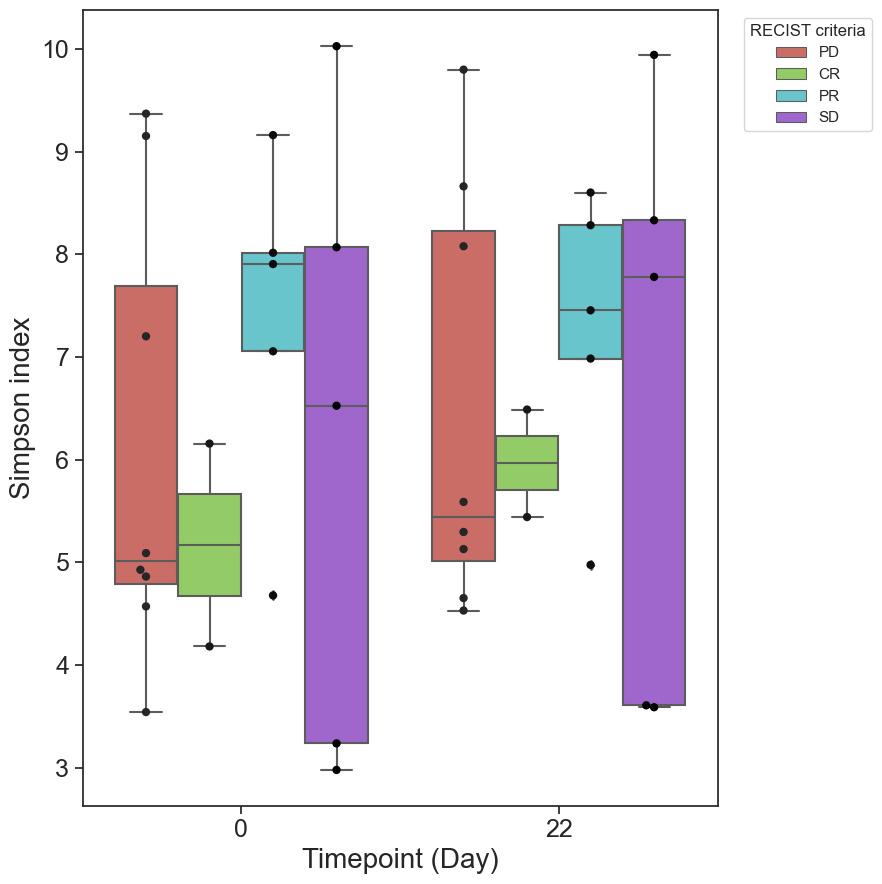

In [140]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"]))))
p = sns.boxplot(x="Timepoint", y="L_identity_q_2", hue="RECIST criteria",
                 data=divP1_identity_q2_treatment_time, palette=cmap)
p = sns.swarmplot(x="Timepoint", y="L_identity_q_2", hue="RECIST criteria",data=divP1_identity_q2_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)
# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"])))], labels[0:len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"])))], 
                   title = "RECIST criteria", loc=2, bbox_to_anchor=(1.03, 1))


#p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Timepoint (Day)", fontsize = 20)
plt.ylabel("Simpson index", fontsize = 20)

plt.tight_layout()
plt.savefig(wdir_path + "Gini_Simpson_index_barplot.pdf")

### Shannon vs Gini-Simpson 

In [141]:
divP_Shannon_Gini = divP1_identity_q2_treatment_time.copy()
divP_Shannon_Gini["L_identity_q_1"] = divP1_identity_q1_treatment_time["L_identity_q_1"]
divP_Shannon_Gini

L_identity_q_2  Timepoint RECIST criteria L_identity_q_1
0        5.089341          0              PD       8.727558
1        4.570001          0              PD       7.615708
2        6.156574          0              CR       9.558237
3        9.154247          0              PD      10.238432
4         7.20227          0              PD      10.168664
5         9.16293          0              PR      10.338952
6        3.540471          0              PD       7.160568
7        2.976326          0              SD       7.189775
8        4.179965          0              CR       8.695653
9        8.069964          0              SD       9.369473
10       3.235066          0              SD       7.113448
11       4.677221          0              PR       7.543351
12       8.016323          0              PR      10.062869
13       7.056038          0              PR       9.702688
14       4.927232          0              PD       8.914827
15       6.525476          0              SD       9.379648
16       7.906278          0              PR        9.99885
17      10.029432          0              SD       10.35412
18       4.861126          0              PD       9.419741
19       9.371984          0              PD      10.392902
20       9.944743         22              SD      10.343483
21       7.455443         22              PR       9.831398
22       8.332814         22              SD       9.451248
23       8.079888         22              PD      10.122079
24       8.663371         22              PD      10.153175
25       5.440952         22              CR       9.415312
26       4.974965         22              PR       7.980428
27       5.128618         22              PD        9.53108
28       3.606033         22              SD       7.687092
29        9.80109         22              PD       10.41926
30       6.488446         22              CR       9.516257
31       4.651388         22              PD       7.787821
32       8.284857         22              PR      10.117495
33       3.587368         22              SD       7.966227
34       5.588437         22              PD       8.648809
35       6.985226         22              PR        9.52534
36       5.295608         22              PD       9.066394
37       7.781055         22              SD       9.846737
38       4.529624         22              PD       8.480017
39       8.603544         22              PR      10.053914

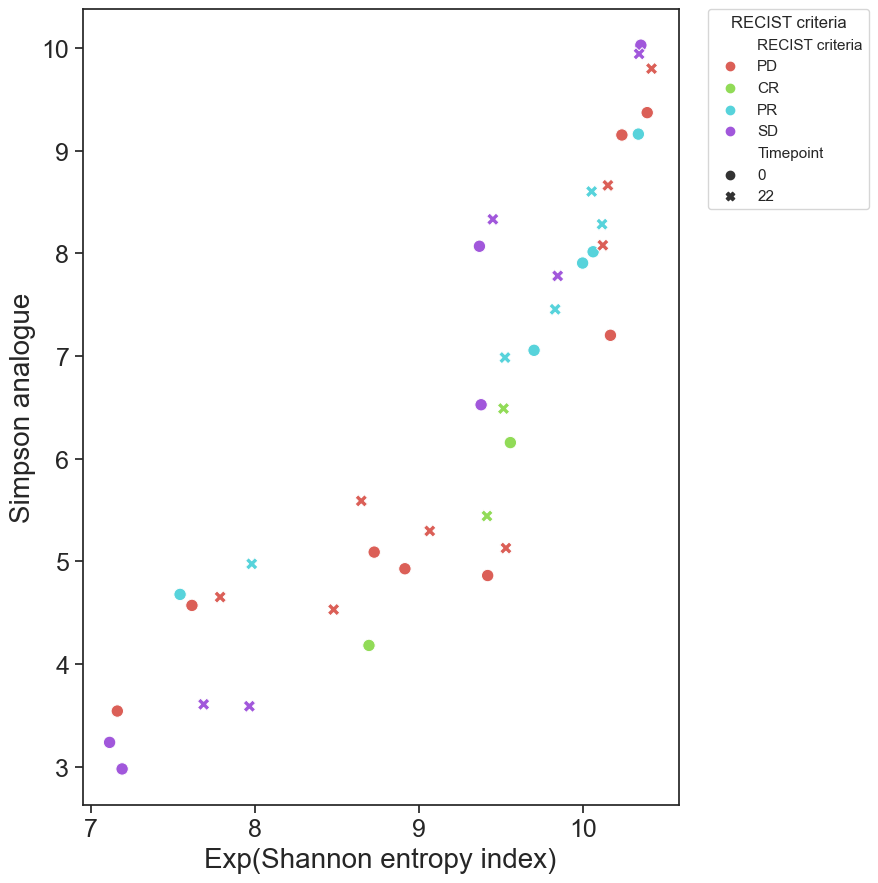

In [142]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP_Shannon_Gini["RECIST criteria"]))))
p = sns.scatterplot(x="L_identity_q_1", y="L_identity_q_2", 
                     data=divP_Shannon_Gini,
                     hue="RECIST criteria", palette=cmap,  
                     style = "Timepoint", 
                    s = 80
                   )




p.legend(title = "RECIST criteria", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Exp(Shannon entropy index)", fontsize = 20)
plt.ylabel("Simpson analogue", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Shannon_vs_Gini_Simpson_index_scatter_plot.pdf")




# Hierarchical clustering 

## Cluster divP features 

In [143]:
divP_features_HC = divP_features_treatment_time.copy()

divP_features_HC = divP_features_HC.set_index(["RECIST criteria", "Timepoint"])

divP_features_HC

identity_64.0_area  identity_32.0_area  \
RECIST criteria Timepoint                                           
PD              0                    0.003154            0.052764   
                0                    0.002795            0.040914   
CR              0                    0.003767            0.057244   
PD              0                    0.004811            0.086275   
                0                    0.004981            0.087676   
PR              0                    0.005690            0.094025   
PD              0                    0.004172            0.045051   
SD              0                    0.006223            0.056192   
CR              0                    0.002701            0.047180   
SD              0                    0.005433            0.064419   
                0                    0.001779            0.028917   
PR              0                    0.001688            0.026617   
                0                    0.005280            0.087440   
                0                    0.004988            0.080530   
PD              0                    0.012950            0.117370   
SD              0                    0.004726            0.073446   
PR              0                    0.003969            0.068071   
SD              0                    0.008340            0.165351   
PD              0                    0.005319            0.111252   
                0                    0.005639            0.105352   
SD              22                   0.007502            0.126206   
PR              22                   0.031658            0.195414   
SD              22                   0.005107            0.063750   
PD              22                   0.005256            0.087447   
                22                   0.004393            0.075845   
CR              22                   0.003474            0.056711   
PR              22                   0.002096            0.030749   
PD              22                   0.004532            0.072749   
SD              22                   0.002325            0.035830   
PD              22                   0.006197            0.112708   
CR              22                   0.003852            0.059167   
PD              22                   0.002713            0.041293   
PR              22                   0.004876            0.081102   
SD              22                   0.003749            0.048608   
PD              22                   0.004027            0.053487   
PR              22                   0.004588            0.071628   
PD              22                   0.004677            0.068403   
SD              22                   0.005203            0.079115   
PD              22                   0.003651            0.052283   
PR              22                   0.003805            0.066967   

                           identity_16.0_area  identity_8.0_area  \
RECIST criteria Timepoint                                          
PD              0                    1.358875           6.302410   
                0                    1.049624           5.241175   
CR              0                    1.527558           7.852819   
PD              0                    2.484636          18.868373   
                0                    2.146448          10.377730   
PR              0                    2.554675          17.263229   
PD              0                    1.064425           5.008369   
SD              0                    1.000032           4.740312   
CR              0                    1.309931           6.086245   
SD              0                    1.585211          13.402917   
                0                    0.879466           4.618687   
PR              0                    0.864155           4.885813   
                0                    2.160879          12.523683   
                0                    1.842356           9.801190   
PD              0                    1.5

<Figure size 600x800 with 0 Axes>

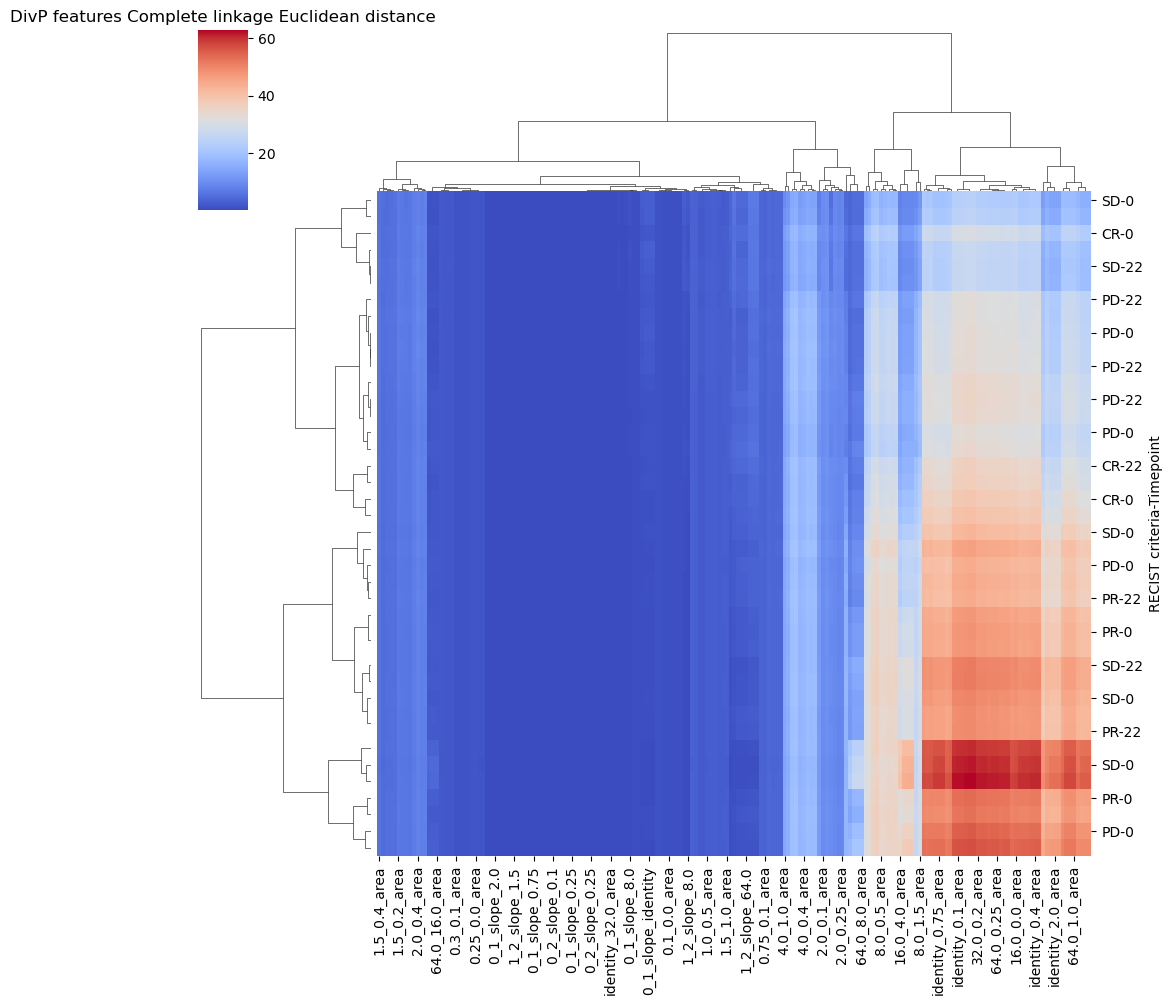

In [144]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_features_HC,
               method='complete',
                metric='euclidean',
              cmap="coolwarm")
if not os.path.isdir(wdir_path+"heatmaps/"):
    os.makedirs(wdir_path+"heatmaps/", exist_ok=False)

plt.title("DivP features Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_divP_features.png", bbox_inches='tight')


## Cluster true diversity

In [145]:
divP_qDZ_HC = divP1_all_df.copy()

divP_qDZ_HC = divP_qDZ_HC.set_index(["RECIST criteria", "Timepoint"])

divP_qDZ_HC = divP_qDZ_HC.drop(["unique_CDR3s", "patient", "sample_name", "sample_type"], axis = 1)
divP_qDZ_HC

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4  \
RECIST criteria Timepoint                                                     
PD              0          0.080324  0.080305  0.080286  0.080267  0.080248   
                0           0.08131    0.0813  0.081289  0.081279  0.081268   
CR              0          0.076677  0.076659  0.076641  0.076623  0.076606   
PD              0          0.074625  0.074609  0.074593  0.074576   0.07456   
                0          0.073666  0.073645  0.073623  0.073601   0.07358   
PR              0          0.073927  0.073911  0.073896   0.07388  0.073864   
PD              0          0.079482  0.079467  0.079452  0.079437  0.079421   
SD              0          0.083516  0.083502  0.083489  0.083475  0.083462   
CR              0          0.079534  0.079521  0.079508  0.079494  0.079481   
SD              0          0.075801  0.075779  0.075757  0.075736  0.075714   
                0          0.080873  0.080847  0.080821  0.080794  0.080768   
PR              0          0.083094  0.083081  0.083068  0.083055  0.083042   
                0          0.073693  0.073673  0.073653  0.073633  0.073614   
                0          0.075603  0.075581  0.075559  0.075537  0.075516   
PD              0          0.074545  0.074528  0.074511  0.074494  0.074477   
SD              0          0.075521  0.075498  0.075475  0.075452  0.075429   
PR              0           0.07517  0.075151  0.075133  0.075114  0.075096   
SD              0          0.071877  0.071863  0.071849  0.071834   0.07182   
PD              0          0.076792  0.076778  0.076765  0.076751  0.076737   
                0          0.074148  0.074133  0.074119  0.074104  0.074089   
SD              22         0.072712  0.072696  0.072681  0.072666  0.072651   
PR              22         0.078068  0.078048  0.078029  0.078009  0.077989   
SD              22         0.073914  0.073896  0.073879  0.073862  0.073844   
PD              22         0.073976  0.073953  0.073931  0.073909  0.073888   
                22         0.075472  0.075455  0.075439  0.075422  0.075406   
CR              22         0.078242  0.078225  0.078209  0.078192  0.078176   
PR              22         0.082234  0.082222   0.08221  0.082198  0.082186   
PD              22         0.077082  0.077062  0.077043  0.077024  0.077005   
SD              22         0.083537  0.083529  0.083521  0.083513  0.083505   
PD              22         0.073975  0.073961  0.073948  0.073934  0.073921   
CR              22         0.077335  0.077315  0.077295  0.077274  0.077254   
PD              22          0.08115  0.081136  0.081122  0.081107  0.081093   
PR              22         0.073942  0.073924  0.073906  0.073888   0.07387   
SD              22         0.082048  0.082032  0.082016     0.082  0.081984   
PD              22         0.077018     0.077  0.076983  0.076965  0.076947   
PR              22         0.076997  0.076975  0.076954  0.076932  0.076911   
PD              22         0.075809  0.075791  0.075774  0.075757  0.075739   
SD              22         0.074093   0.07407  0.074048  0.074025  0.074003   
PD              22          0.08008  0.080064  0.080047  0.080031  0.080015   
PR              22         0.075392  0.075374  0.075356  0.075338   0.07532   

                          L_0.1_q_5 L_0.1_q_6 L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  \
RECIST criteria Timepoint                                                      
PD              0          0.080229  0.080211    0.06773  0.160479  0.160403   
                0          0.081258  0.081247   0.069459   0.16241  0.162368   
CR              0          0.076588   0.07657   0.064366  0.153242  0.153169   
PD              0          0.074544  0.074528   0.063342  0.149154  0.149089   
                0          0.073559  0.073538   0.062188  0.147238   0.14715   
PR              0          0.073849  0.073833   0.062864  0.147761  0.147697   
PD              0          0.079406  0.079391   0.066798  0.158657 

In [146]:
divP_qDZ_HC.isnull().values.any()

False

In [147]:
divP_qDZ_HC = divP_qDZ_HC.apply(pd.to_numeric) 

In [148]:
divP_qDZ_HC.dtypes

L_0.1_q_0          float64
L_0.1_q_1          float64
L_0.1_q_2          float64
L_0.1_q_3          float64
L_0.1_q_4          float64
                    ...   
L_identity_q_3     float64
L_identity_q_4     float64
L_identity_q_5     float64
L_identity_q_6     float64
L_identity_q_11    float64
Length: 128, dtype: object

<Figure size 600x800 with 0 Axes>

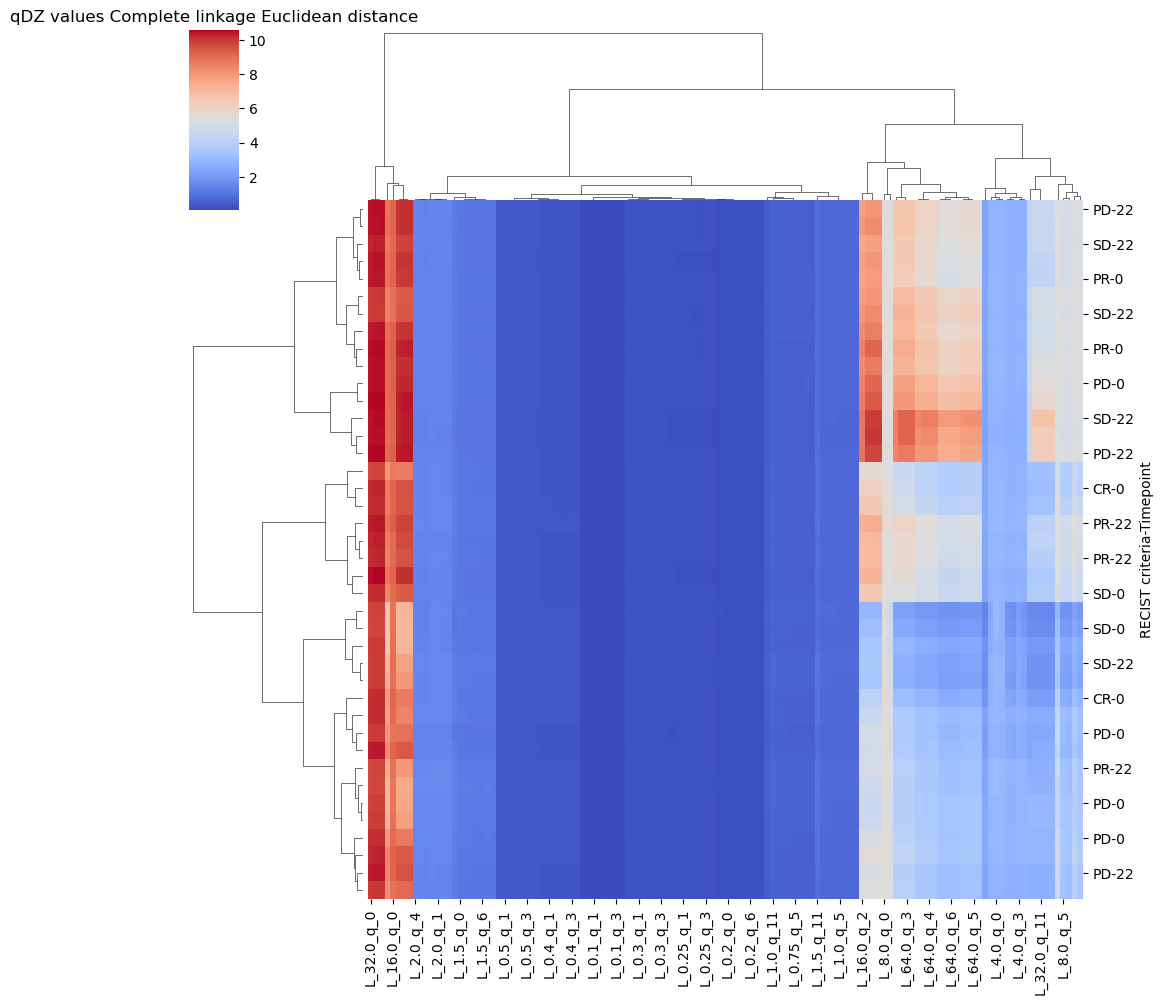

In [149]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_qDZ_HC,
               method='complete',
                metric='euclidean',
                cmap="coolwarm"
                   )
if not os.path.isdir(wdir_path+"heatmaps/"):
    os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
plt.title("qDZ values Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_qDZ.png", bbox_inches='tight')
